In [1]:
from google.colab import files
uploaded = files.upload()

Saving api_data_aadhar_enrolment_0_500000.csv to api_data_aadhar_enrolment_0_500000.csv
Saving api_data_aadhar_enrolment_500000_1000000.csv to api_data_aadhar_enrolment_500000_1000000.csv
Saving api_data_aadhar_enrolment_1000000_1006029.csv to api_data_aadhar_enrolment_1000000_1006029.csv


# Aadhaar Enrolment Structure Analysis - Comprehensive Notebook

In [2]:
## Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy import stats
from scipy.stats import chi2_contingency
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set visualization styles
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 10

## 1. DATA LOADING AND INITIAL EXPLORATION

In [4]:
# Load files
files_list = ["api_data_aadhar_enrolment_0_500000.csv",
    "api_data_aadhar_enrolment_500000_1000000.csv",
    "api_data_aadhar_enrolment_1000000_1006029.csv"]  # Update with your file paths
df = pd.concat([pd.read_csv(f) for f in files_list], ignore_index=True)

In [5]:
print("="*80)
print("DATASET OVERVIEW")
print("="*80)
print(f"\nDataset Shape: {df.shape}")
print(f"Total Records: {df.shape[0]:,}")
print(f"Total Features: {df.shape[1]}")

print("\n" + "="*80)
print("COLUMN INFORMATION")
print("="*80)
print(df.info())

print("\n" + "="*80)
print("FIRST FEW RECORDS")
print("="*80)
print(df.head(10))

print("\n" + "="*80)
print("BASIC STATISTICS")
print("="*80)
print(df.describe())

print("\n" + "="*80)
print("MISSING VALUES ANALYSIS")
print("="*80)
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Missing Count': missing, 'Percentage': missing_pct})
print(missing_df[missing_df['Missing Count'] > 0].sort_values('Missing Count', ascending=False))

DATASET OVERVIEW

Dataset Shape: (1006029, 7)
Total Records: 1,006,029
Total Features: 7

COLUMN INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1006029 entries, 0 to 1006028
Data columns (total 7 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   date            1006029 non-null  object
 1   state           1006029 non-null  object
 2   district        1006029 non-null  object
 3   pincode         1006029 non-null  int64 
 4   age_0_5         1006029 non-null  int64 
 5   age_5_17        1006029 non-null  int64 
 6   age_18_greater  1006029 non-null  int64 
dtypes: int64(4), object(3)
memory usage: 53.7+ MB
None

FIRST FEW RECORDS
         date          state          district  pincode  age_0_5  age_5_17  \
0  02-03-2025      Meghalaya  East Khasi Hills   793121       11        61   
1  09-03-2025      Karnataka   Bengaluru Urban   560043       14        33   
2  09-03-2025  Uttar Pradesh      Kanpur Nagar   208001 

## 2. DATA PREPROCESSING

In [6]:
# Convert date column
df['date'] = pd.to_datetime(df['date'], dayfirst=True, errors='coerce')

In [7]:
# Create enrolment metrics
df['total_enrolment'] = df['age_0_5'] + df['age_5_17'] + df['age_18_greater']

In [8]:
# Share calculations
df['child_share'] = df['age_0_5'] / df['total_enrolment']
df['school_age_share'] = df['age_5_17'] / df['total_enrolment']
df['adult_share'] = df['age_18_greater'] / df['total_enrolment']

In [9]:
# Dependency ratio
df['dependency_ratio'] = (df['age_0_5'] + df['age_5_17']) / df['age_18_greater']

In [10]:
# Replace infinities
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [11]:
# Extract temporal features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter
df['year_month'] = df['date'].dt.to_period('M')
df['day_of_week'] = df['date'].dt.dayofweek
df['week_of_year'] = df['date'].dt.isocalendar().week

In [12]:
print("\n" + "="*80)
print("PROCESSED DATASET SAMPLE")
print("="*80)
print(df[['date', 'state', 'age_0_5', 'age_5_17', 'age_18_greater',
          'total_enrolment', 'child_share', 'school_age_share',
          'adult_share', 'dependency_ratio']].head(10))


PROCESSED DATASET SAMPLE
        date          state  age_0_5  age_5_17  age_18_greater  \
0 2025-03-02      Meghalaya       11        61              37   
1 2025-03-09      Karnataka       14        33              39   
2 2025-03-09  Uttar Pradesh       29        82              12   
3 2025-03-09  Uttar Pradesh       62        29              15   
4 2025-03-09      Karnataka       14        16              21   
5 2025-03-09          Bihar       20        49              12   
6 2025-03-09          Bihar       23        24              42   
7 2025-03-09  Uttar Pradesh       26        60              14   
8 2025-03-09  Uttar Pradesh       28        26              10   
9 2025-03-09          Bihar       30        48              10   

   total_enrolment  child_share  school_age_share  adult_share  \
0              109     0.100917          0.559633     0.339450   
1               86     0.162791          0.383721     0.453488   
2              123     0.235772          0.666667

## 3. UNIVARIATE ANALYSIS

In [13]:
print("\n" + "="*80)
print("UNIVARIATE ANALYSIS")
print("="*80)


UNIVARIATE ANALYSIS


### 3.1 Total Enrolment Distribution

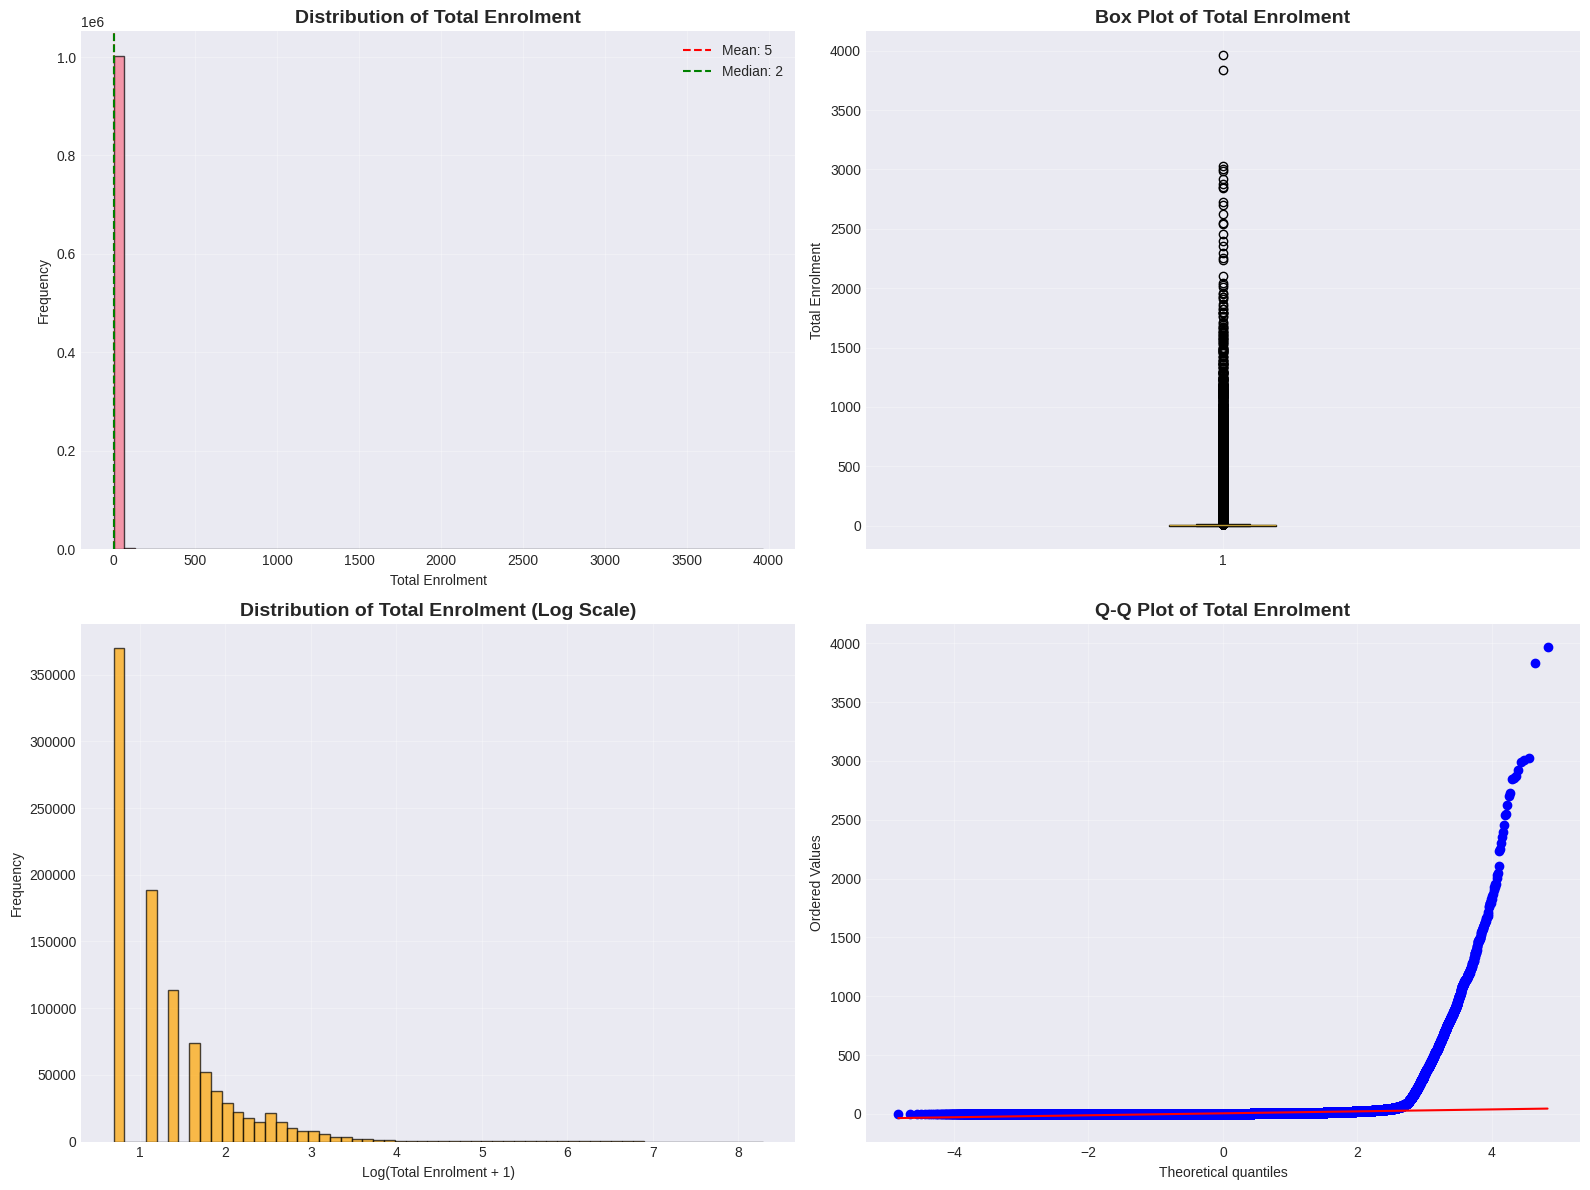

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Histogram
axes[0, 0].hist(df['total_enrolment'].dropna(), bins=60, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Total Enrolment', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Total Enrolment')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df['total_enrolment'].mean(), color='red',
                    linestyle='--', label=f'Mean: {df["total_enrolment"].mean():.0f}')
axes[0, 0].axvline(df['total_enrolment'].median(), color='green',
                    linestyle='--', label=f'Median: {df["total_enrolment"].median():.0f}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Box plot
bp = axes[0, 1].boxplot(df['total_enrolment'].dropna(), vert=True, patch_artist=True)
bp['boxes'][0].set_facecolor('lightblue')
axes[0, 1].set_title('Box Plot of Total Enrolment', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Total Enrolment')
axes[0, 1].grid(True, alpha=0.3)

# Log-scale histogram
log_enrolment = np.log1p(df['total_enrolment'].dropna())
axes[1, 0].hist(log_enrolment, bins=60, edgecolor='black', alpha=0.7, color='orange')
axes[1, 0].set_title('Distribution of Total Enrolment (Log Scale)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Log(Total Enrolment + 1)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3)

# Q-Q Plot
stats.probplot(df['total_enrolment'].dropna(), dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot of Total Enrolment', fontsize=14, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.2 Age Group Distributions

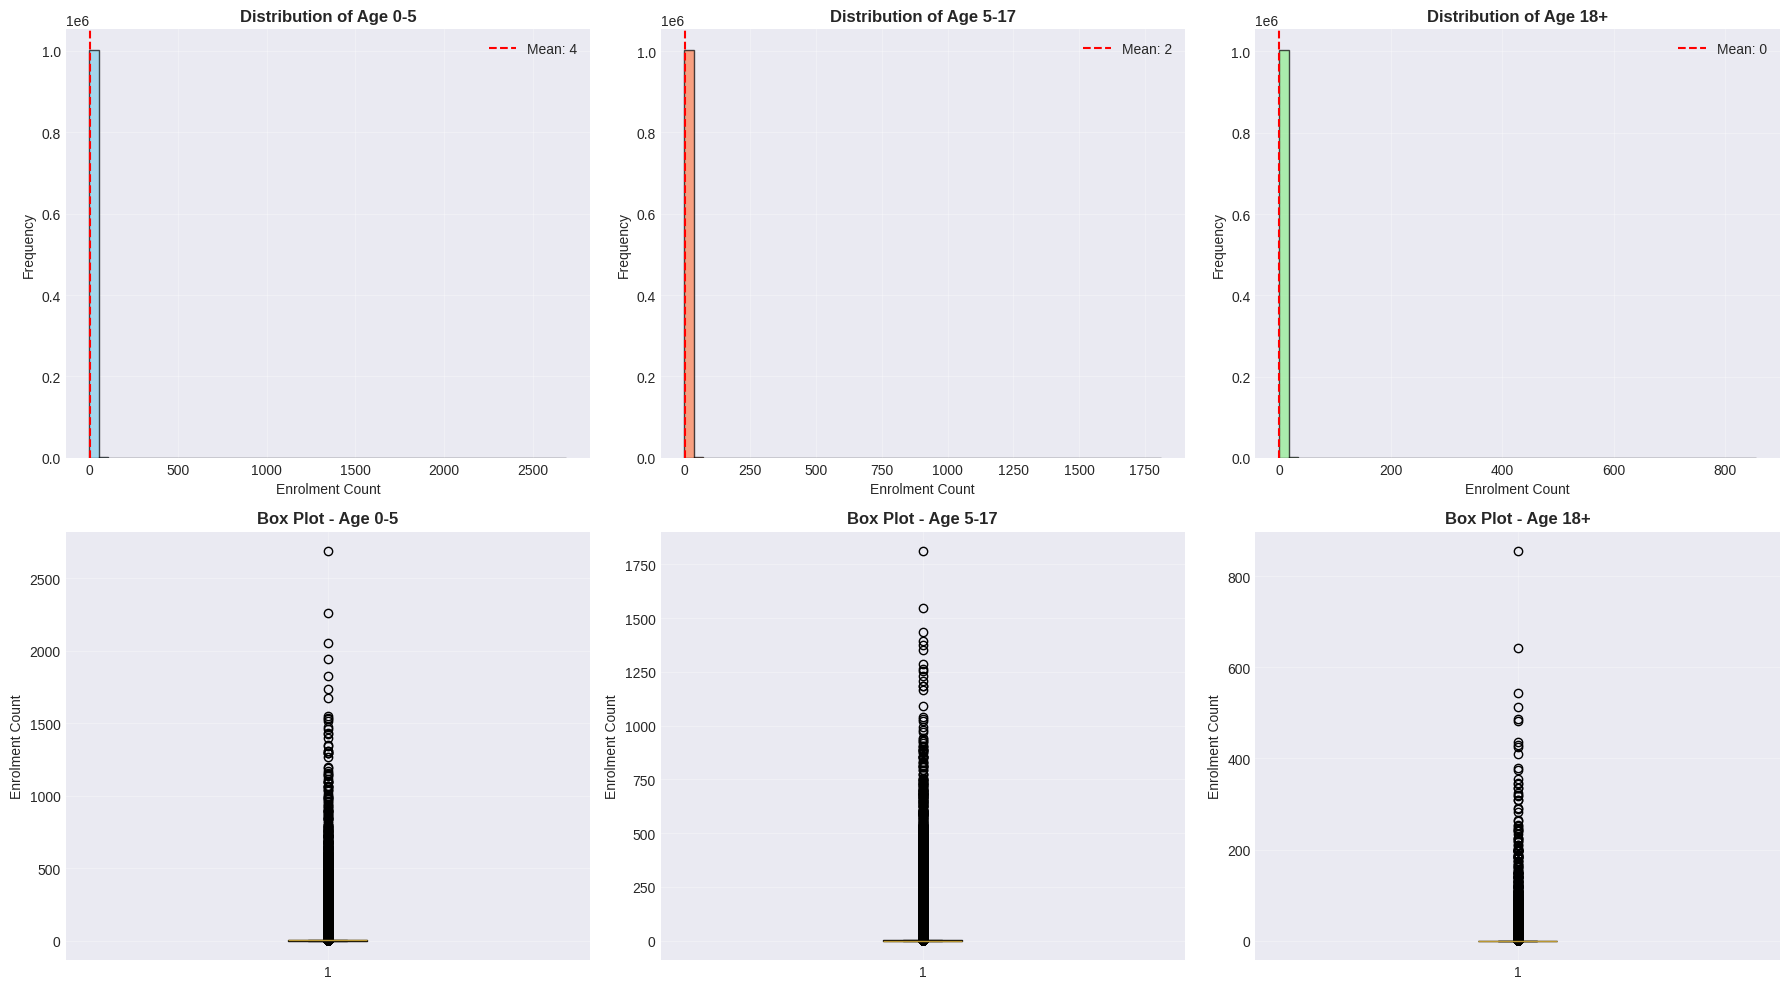

In [16]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

age_groups = ['age_0_5', 'age_5_17', 'age_18_greater']
titles = ['Age 0-5', 'Age 5-17', 'Age 18+']
colors = ['skyblue', 'coral', 'lightgreen']

for idx, (col, title, color) in enumerate(zip(age_groups, titles, colors)):
    # Histogram
    axes[0, idx].hist(df[col].dropna(), bins=50, edgecolor='black', alpha=0.7, color=color)
    axes[0, idx].set_title(f'Distribution of {title}', fontsize=12, fontweight='bold')
    axes[0, idx].set_xlabel('Enrolment Count')
    axes[0, idx].set_ylabel('Frequency')
    axes[0, idx].axvline(df[col].mean(), color='red', linestyle='--',
                         label=f'Mean: {df[col].mean():.0f}')
    axes[0, idx].legend()
    axes[0, idx].grid(True, alpha=0.3)

    # Box plot
    bp = axes[1, idx].boxplot(df[col].dropna(), vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor(color)
    axes[1, idx].set_title(f'Box Plot - {title}', fontsize=12, fontweight='bold')
    axes[1, idx].set_ylabel('Enrolment Count')
    axes[1, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [17]:
# Summary statistics for age groups
print("\n" + "="*80)
print("AGE GROUP SUMMARY STATISTICS")
print("="*80)
age_summary = df[age_groups].describe()
print(age_summary)


AGE GROUP SUMMARY STATISTICS
            age_0_5      age_5_17  age_18_greater
count  1.006029e+06  1.006029e+06    1.006029e+06
mean   3.525709e+00  1.710074e+00    1.673441e-01
std    1.753851e+01  1.436963e+01    3.220525e+00
min    0.000000e+00  0.000000e+00    0.000000e+00
25%    1.000000e+00  0.000000e+00    0.000000e+00
50%    2.000000e+00  0.000000e+00    0.000000e+00
75%    3.000000e+00  1.000000e+00    0.000000e+00
max    2.688000e+03  1.812000e+03    8.550000e+02


### 3.3 Share Distributions

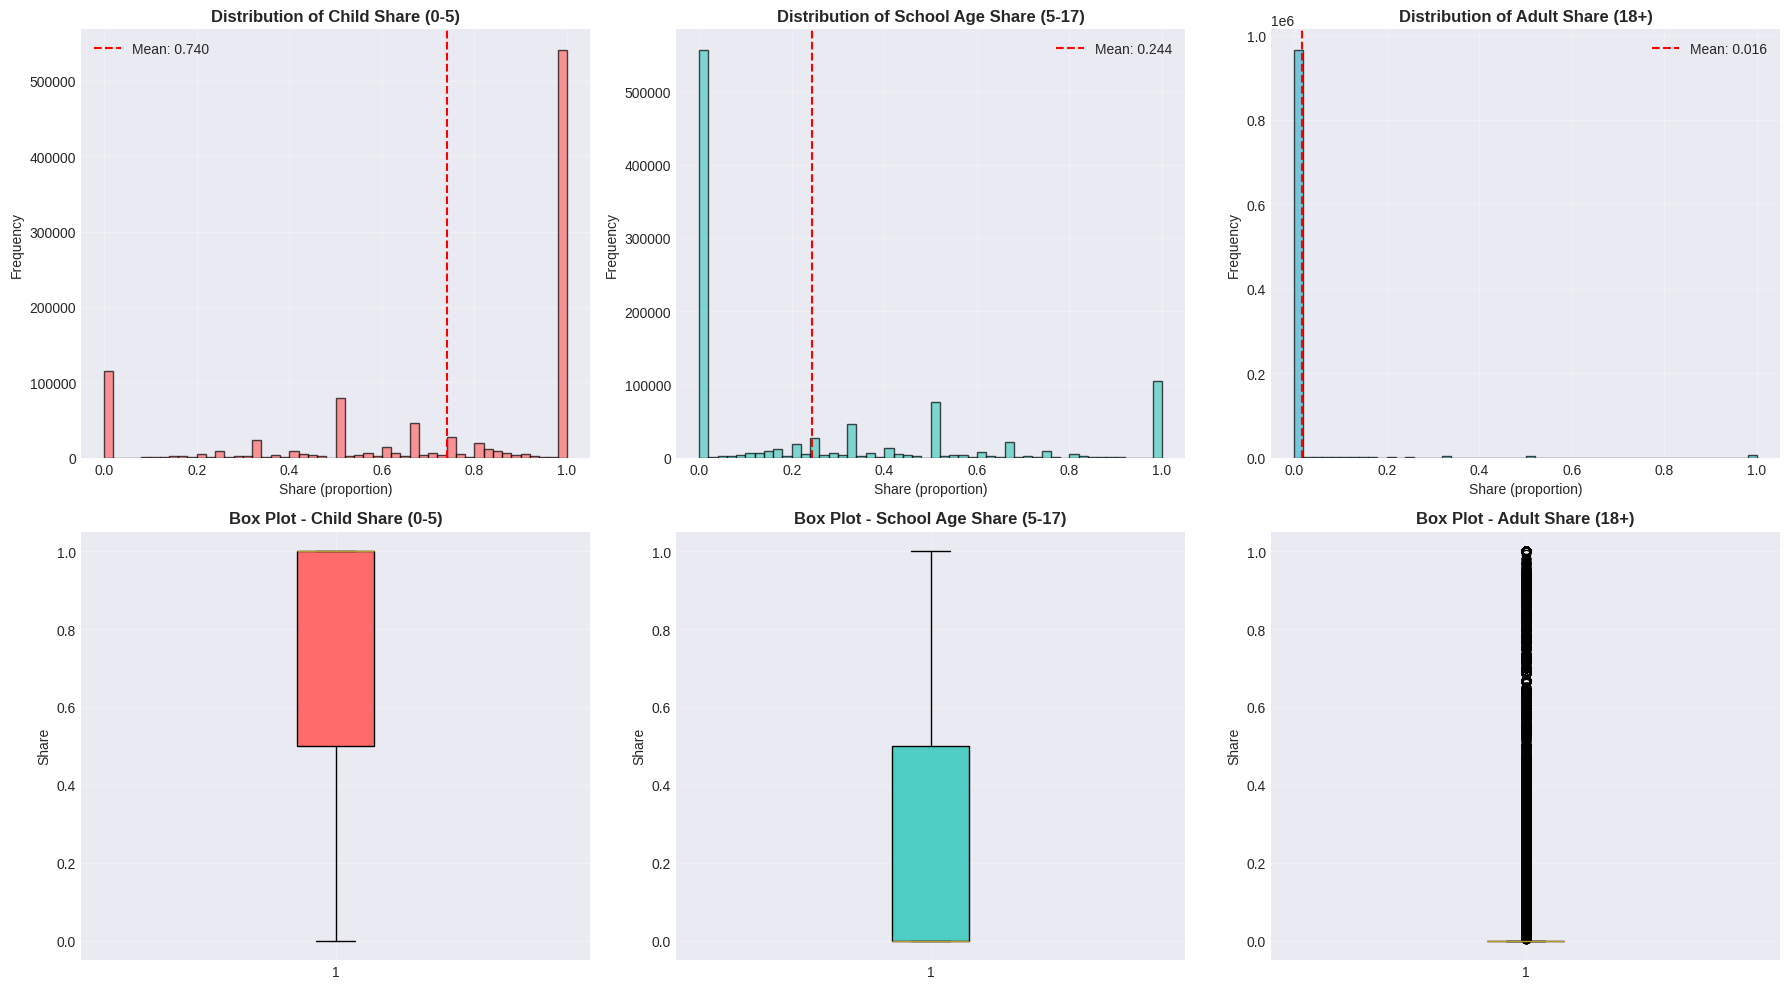

In [18]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

share_cols = ['child_share', 'school_age_share', 'adult_share']
share_titles = ['Child Share (0-5)', 'School Age Share (5-17)', 'Adult Share (18+)']
share_colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']

for idx, (col, title, color) in enumerate(zip(share_cols, share_titles, share_colors)):
    data = df[col].dropna()

    # Histogram
    axes[0, idx].hist(data, bins=50, edgecolor='black', alpha=0.7, color=color)
    axes[0, idx].set_title(f'Distribution of {title}', fontsize=12, fontweight='bold')
    axes[0, idx].set_xlabel('Share (proportion)')
    axes[0, idx].set_ylabel('Frequency')
    axes[0, idx].axvline(data.mean(), color='red', linestyle='--',
                         label=f'Mean: {data.mean():.3f}')
    axes[0, idx].legend()
    axes[0, idx].grid(True, alpha=0.3)

    # Box plot
    bp = axes[1, idx].boxplot(data, vert=True, patch_artist=True)
    bp['boxes'][0].set_facecolor(color)
    axes[1, idx].set_title(f'Box Plot - {title}', fontsize=12, fontweight='bold')
    axes[1, idx].set_ylabel('Share')
    axes[1, idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### 3.4 Dependency Ratio Distribution

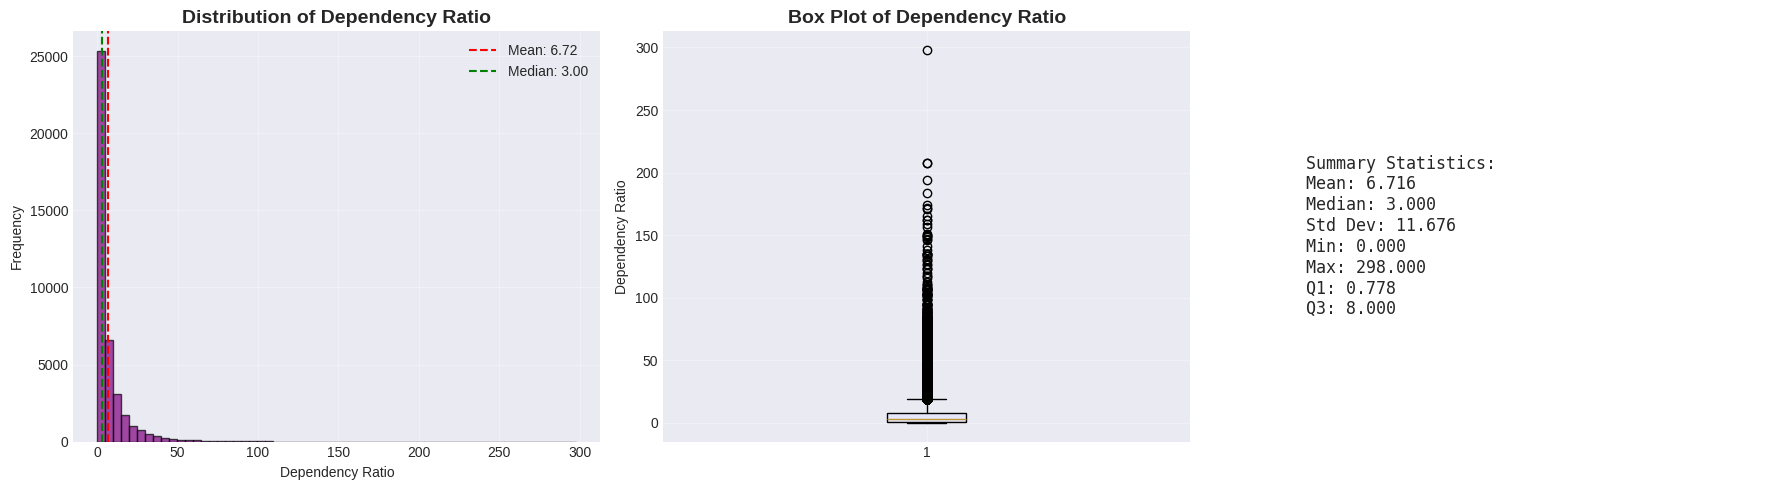

In [20]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

dep_ratio_data = df['dependency_ratio'].dropna()

# Histogram
axes[0].hist(dep_ratio_data, bins=60, edgecolor='black', alpha=0.7, color='purple')
axes[0].set_title('Distribution of Dependency Ratio', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Dependency Ratio')
axes[0].set_ylabel('Frequency')
axes[0].axvline(dep_ratio_data.mean(), color='red', linestyle='--',
                label=f'Mean: {dep_ratio_data.mean():.2f}')
axes[0].axvline(dep_ratio_data.median(), color='green', linestyle='--',
                label=f'Median: {dep_ratio_data.median():.2f}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Box plot
bp = axes[1].boxplot(dep_ratio_data, vert=True, patch_artist=True)
bp['boxes'][0].set_facecolor('lavender')
axes[1].set_title('Box Plot of Dependency Ratio', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Dependency Ratio')
axes[1].grid(True, alpha=0.3)

# Statistics text
stats_text = f"""
Summary Statistics:
Mean: {dep_ratio_data.mean():.3f}
Median: {dep_ratio_data.median():.3f}
Std Dev: {dep_ratio_data.std():.3f}
Min: {dep_ratio_data.min():.3f}
Max: {dep_ratio_data.max():.3f}
Q1: {dep_ratio_data.quantile(0.25):.3f}
Q3: {dep_ratio_data.quantile(0.75):.3f}
"""
axes[2].text(0.1, 0.5, stats_text, fontsize=12, family='monospace',
             verticalalignment='center', transform=axes[2].transAxes)
axes[2].axis('off')

plt.tight_layout()
plt.show()

### 3.5 Temporal Distribution

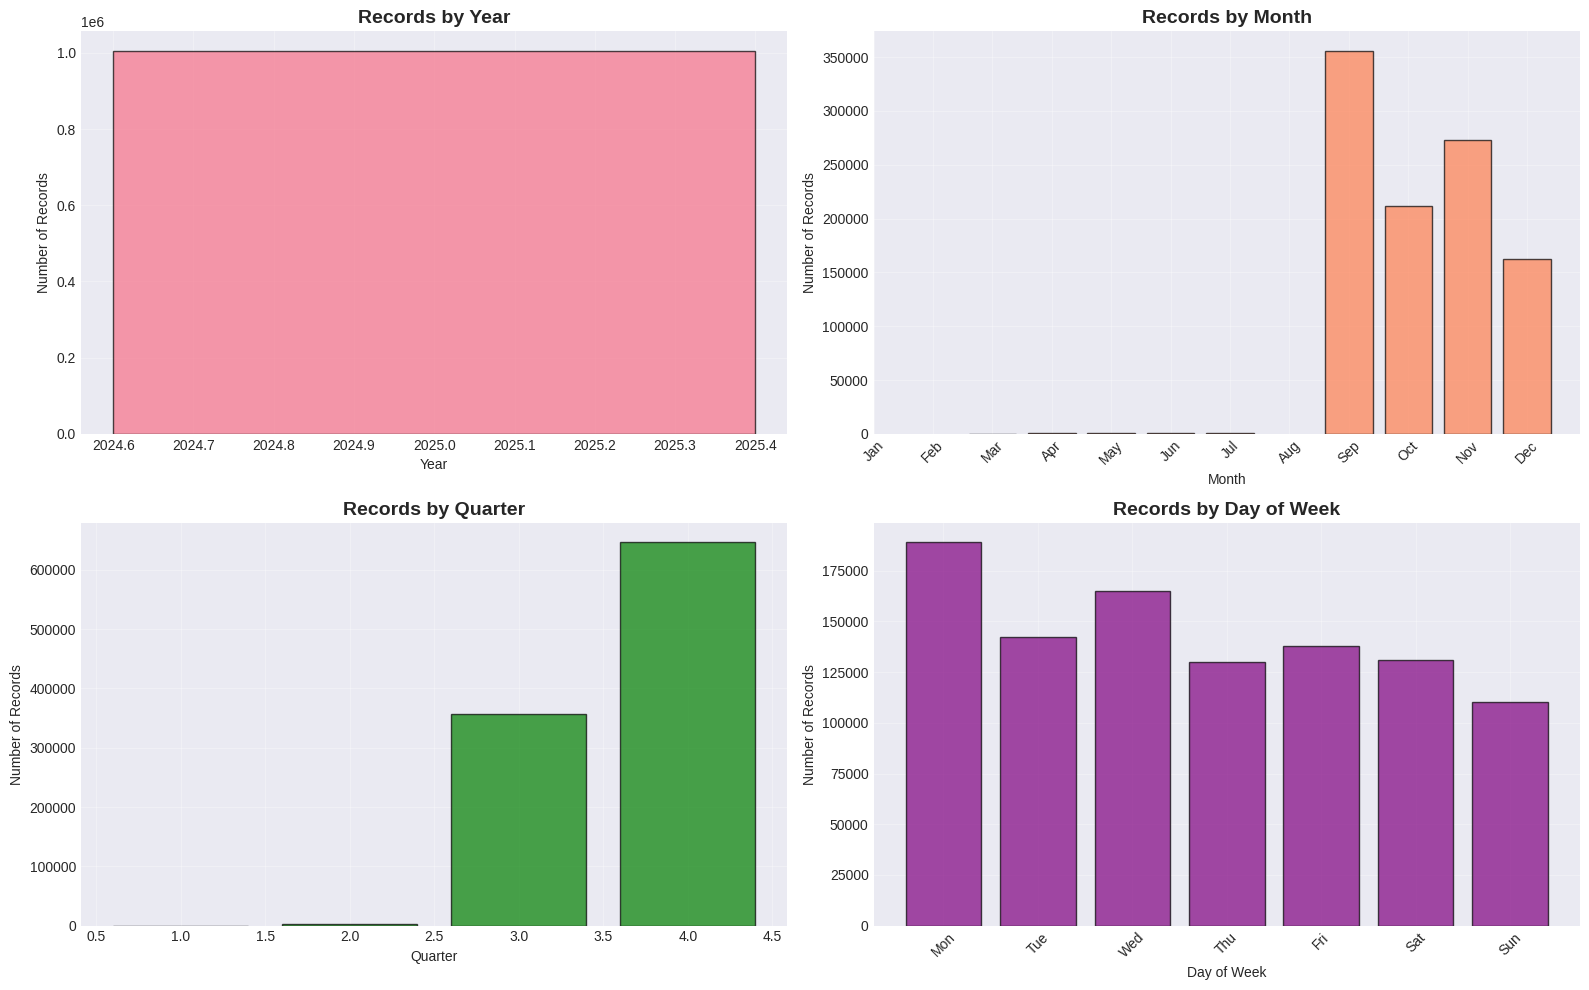

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Year distribution
if 'year' in df.columns:
    year_counts = df['year'].value_counts().sort_index()
    axes[0, 0].bar(year_counts.index, year_counts.values, edgecolor='black', alpha=0.7)
    axes[0, 0].set_title('Records by Year', fontsize=14, fontweight='bold')
    axes[0, 0].set_xlabel('Year')
    axes[0, 0].set_ylabel('Number of Records')
    axes[0, 0].grid(True, alpha=0.3)

# Month distribution
month_counts = df['month'].value_counts().sort_index()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
axes[0, 1].bar(month_counts.index, month_counts.values, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].set_title('Records by Month', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Number of Records')
axes[0, 1].set_xticks(range(1, 13))
axes[0, 1].set_xticklabels(month_names, rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Quarter distribution
quarter_counts = df['quarter'].value_counts().sort_index()
axes[1, 0].bar(quarter_counts.index, quarter_counts.values, edgecolor='black', alpha=0.7, color='green')
axes[1, 0].set_title('Records by Quarter', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Quarter')
axes[1, 0].set_ylabel('Number of Records')
axes[1, 0].grid(True, alpha=0.3)

# Day of week distribution
dow_counts = df['day_of_week'].value_counts().sort_index()
dow_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[1, 1].bar(dow_counts.index, dow_counts.values, edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].set_title('Records by Day of Week', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Day of Week')
axes[1, 1].set_ylabel('Number of Records')
axes[1, 1].set_xticks(range(7))
axes[1, 1].set_xticklabels(dow_names, rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 3.6 State Distribution

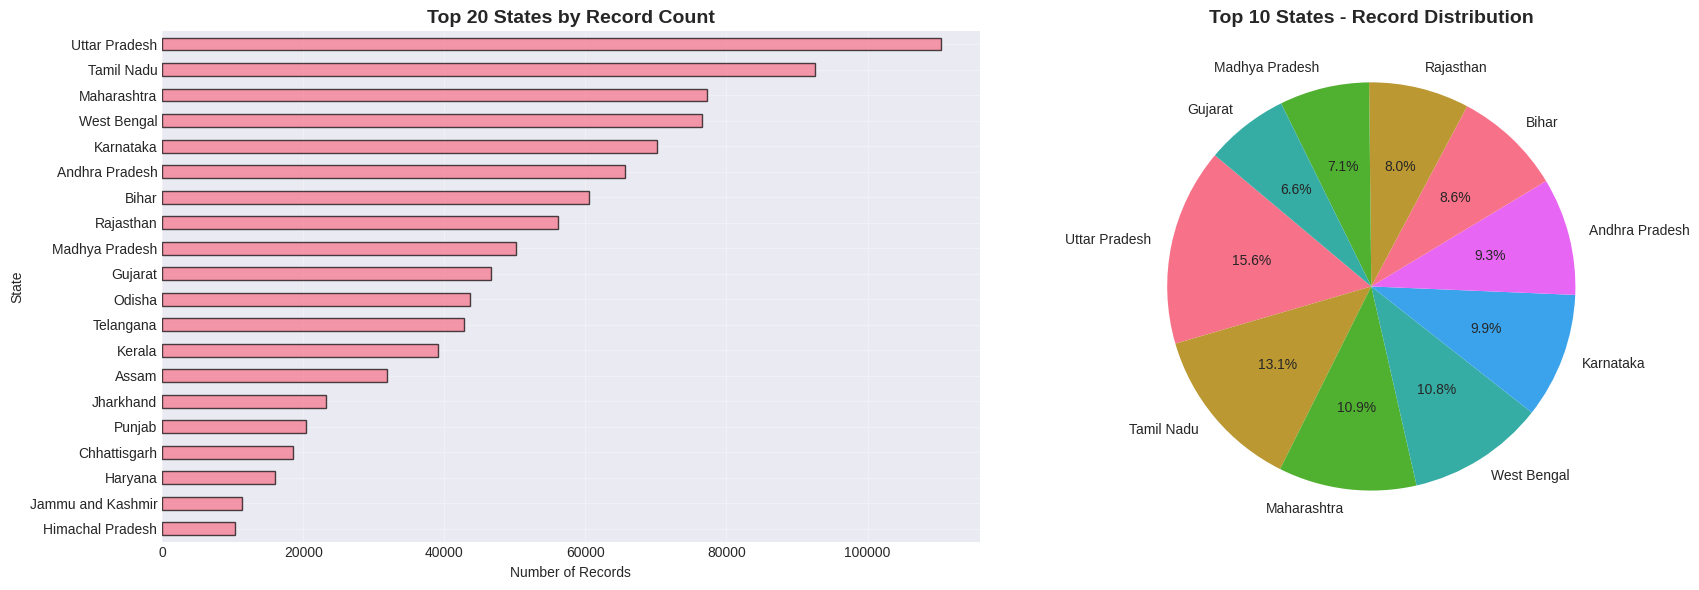


Total unique states: 55
Top 5 states: Uttar Pradesh, Tamil Nadu, Maharashtra, West Bengal, Karnataka


In [22]:
state_counts = df['state'].value_counts().head(20)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Bar chart
state_counts.plot(kind='barh', ax=axes[0], edgecolor='black', alpha=0.7)
axes[0].set_title('Top 20 States by Record Count', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Records')
axes[0].set_ylabel('State')
axes[0].invert_yaxis()
axes[0].grid(True, alpha=0.3)

# Pie chart for top 10
top10_states = state_counts.head(10)
axes[1].pie(top10_states.values, labels=top10_states.index, autopct='%1.1f%%',
            startangle=140)
axes[1].set_title('Top 10 States - Record Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nTotal unique states: {df['state'].nunique()}")
print(f"Top 5 states: {', '.join(state_counts.head(5).index.tolist())}")

## 4. BIVARIATE ANALYSIS

In [ ]:
print("\n" + "="*80)
print("BIVARIATE ANALYSIS")
print("="*80)

### 4.1 Age Group Relationships

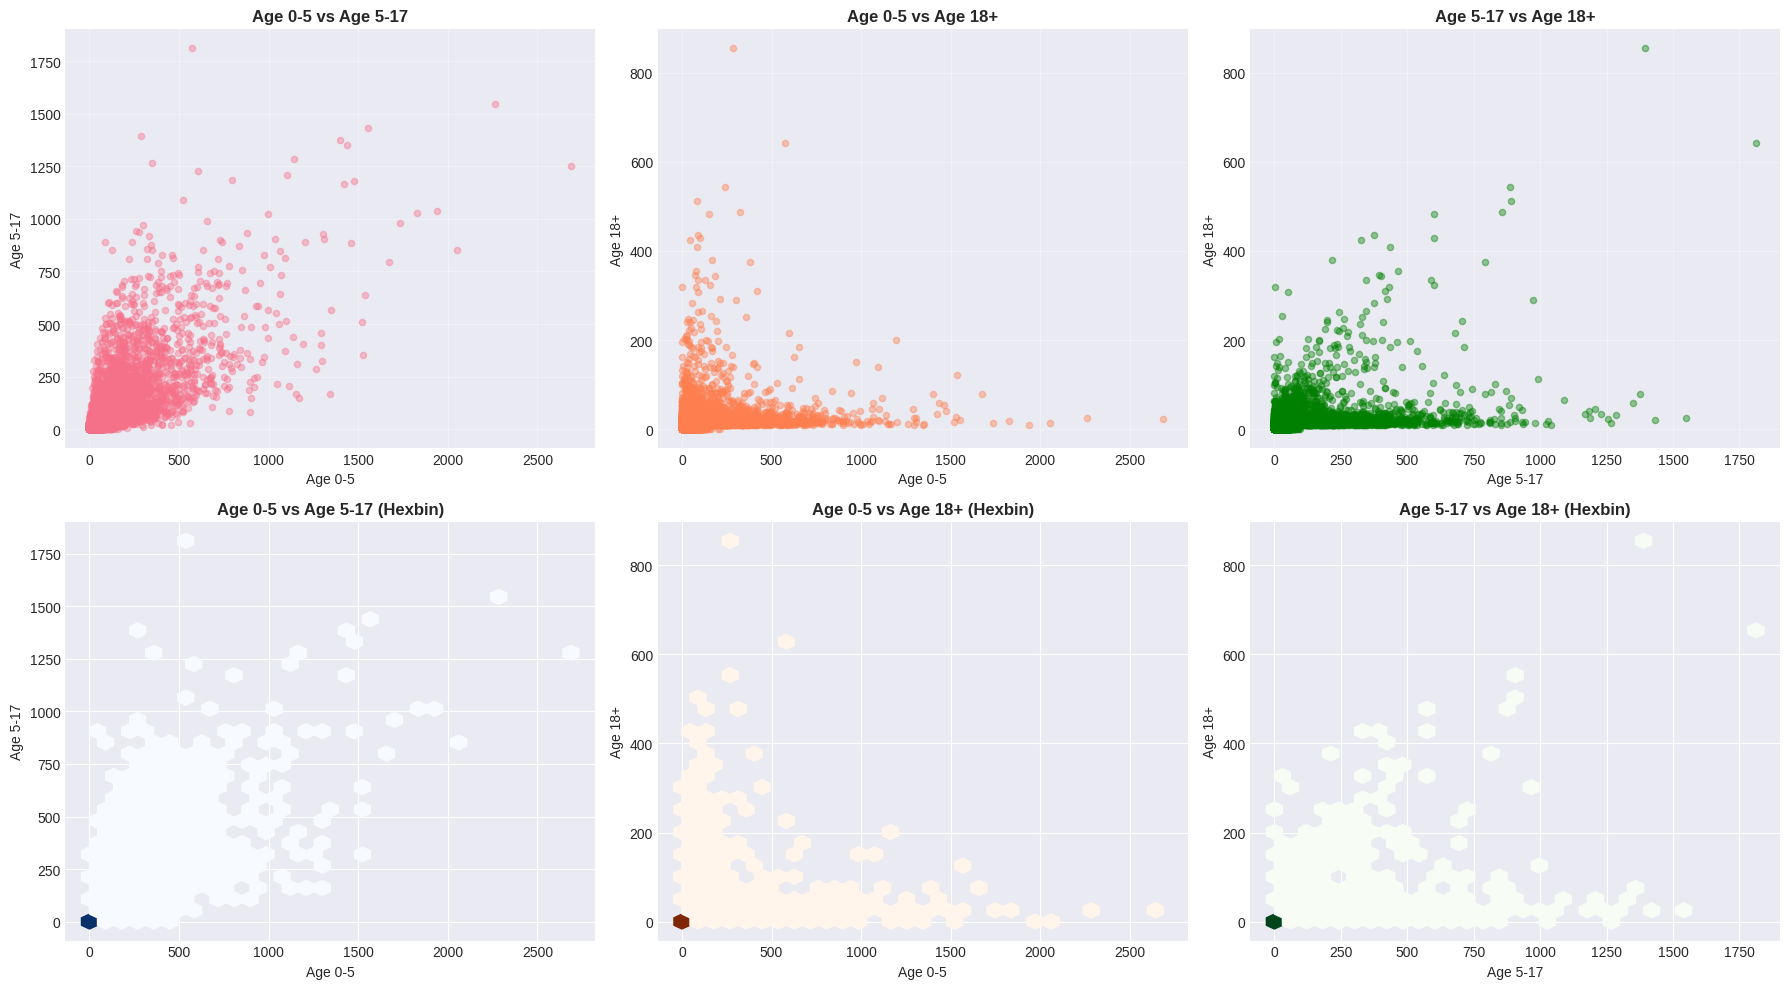

In [23]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Age 0-5 vs Age 5-17
axes[0, 0].scatter(df['age_0_5'], df['age_5_17'], alpha=0.4, s=20)
axes[0, 0].set_title('Age 0-5 vs Age 5-17', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Age 0-5')
axes[0, 0].set_ylabel('Age 5-17')
axes[0, 0].grid(True, alpha=0.3)

# Age 0-5 vs Age 18+
axes[0, 1].scatter(df['age_0_5'], df['age_18_greater'], alpha=0.4, s=20, color='coral')
axes[0, 1].set_title('Age 0-5 vs Age 18+', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Age 0-5')
axes[0, 1].set_ylabel('Age 18+')
axes[0, 1].grid(True, alpha=0.3)

# Age 5-17 vs Age 18+
axes[0, 2].scatter(df['age_5_17'], df['age_18_greater'], alpha=0.4, s=20, color='green')
axes[0, 2].set_title('Age 5-17 vs Age 18+', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Age 5-17')
axes[0, 2].set_ylabel('Age 18+')
axes[0, 2].grid(True, alpha=0.3)

# Hexbin plots for dense relationships
axes[1, 0].hexbin(df['age_0_5'], df['age_5_17'], gridsize=30, cmap='Blues', mincnt=1)
axes[1, 0].set_title('Age 0-5 vs Age 5-17 (Hexbin)', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Age 0-5')
axes[1, 0].set_ylabel('Age 5-17')

axes[1, 1].hexbin(df['age_0_5'], df['age_18_greater'], gridsize=30, cmap='Oranges', mincnt=1)
axes[1, 1].set_title('Age 0-5 vs Age 18+ (Hexbin)', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Age 0-5')
axes[1, 1].set_ylabel('Age 18+')

axes[1, 2].hexbin(df['age_5_17'], df['age_18_greater'], gridsize=30, cmap='Greens', mincnt=1)
axes[1, 2].set_title('Age 5-17 vs Age 18+ (Hexbin)', fontsize=12, fontweight='bold')
axes[1, 2].set_xlabel('Age 5-17')
axes[1, 2].set_ylabel('Age 18+')

plt.tight_layout()
plt.show()

### 4.2 Share Relationships

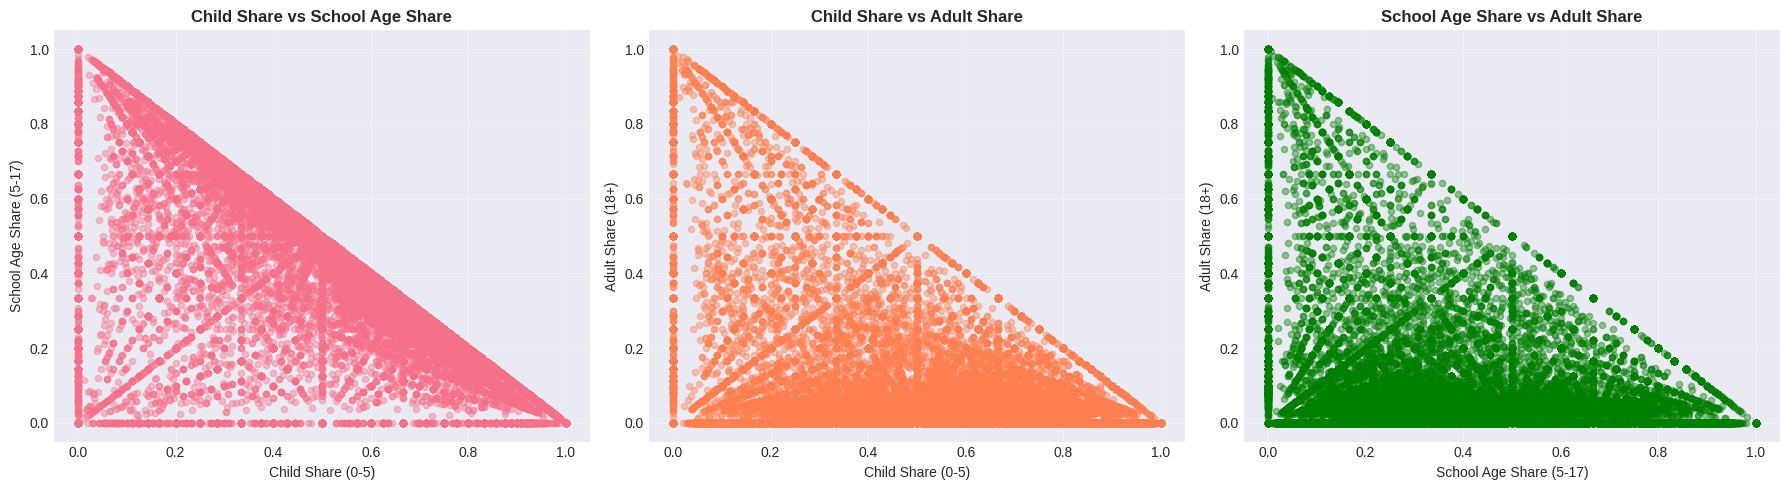

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Child share vs School age share
axes[0].scatter(df['child_share'], df['school_age_share'], alpha=0.4, s=20)
axes[0].set_title('Child Share vs School Age Share', fontsize=12, fontweight='bold')
axes[0].set_xlabel('Child Share (0-5)')
axes[0].set_ylabel('School Age Share (5-17)')
axes[0].grid(True, alpha=0.3)

# Child share vs Adult share
axes[1].scatter(df['child_share'], df['adult_share'], alpha=0.4, s=20, color='coral')
axes[1].set_title('Child Share vs Adult Share', fontsize=12, fontweight='bold')
axes[1].set_xlabel('Child Share (0-5)')
axes[1].set_ylabel('Adult Share (18+)')
axes[1].grid(True, alpha=0.3)

# School age share vs Adult share
axes[2].scatter(df['school_age_share'], df['adult_share'], alpha=0.4, s=20, color='green')
axes[2].set_title('School Age Share vs Adult Share', fontsize=12, fontweight='bold')
axes[2].set_xlabel('School Age Share (5-17)')
axes[2].set_ylabel('Adult Share (18+)')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.3 Dependency Ratio Analysis

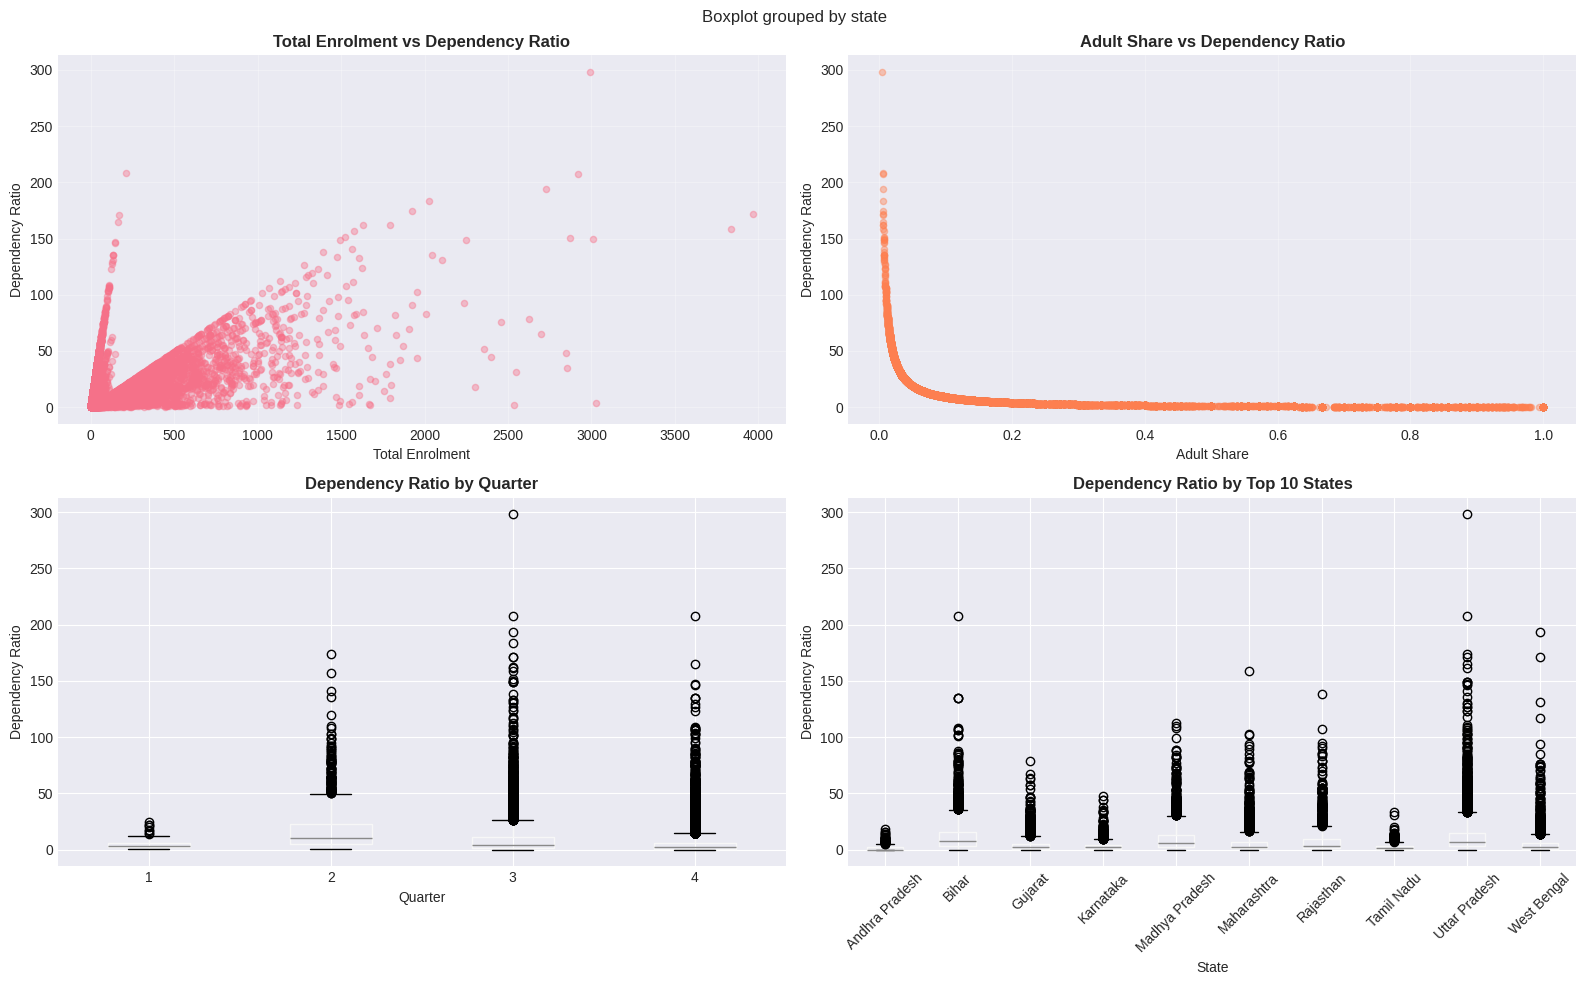

In [25]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Dependency ratio vs Total enrolment
axes[0, 0].scatter(df['total_enrolment'], df['dependency_ratio'], alpha=0.4, s=20)
axes[0, 0].set_title('Total Enrolment vs Dependency Ratio', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Total Enrolment')
axes[0, 0].set_ylabel('Dependency Ratio')
axes[0, 0].grid(True, alpha=0.3)

# Dependency ratio vs Adult share
axes[0, 1].scatter(df['adult_share'], df['dependency_ratio'], alpha=0.4, s=20, color='coral')
axes[0, 1].set_title('Adult Share vs Dependency Ratio', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Adult Share')
axes[0, 1].set_ylabel('Dependency Ratio')
axes[0, 1].grid(True, alpha=0.3)

# Box plot: Dependency ratio by quarter
df.boxplot(column='dependency_ratio', by='quarter', ax=axes[1, 0])
axes[1, 0].set_title('Dependency Ratio by Quarter', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Quarter')
axes[1, 0].set_ylabel('Dependency Ratio')
plt.sca(axes[1, 0])
plt.xticks([1, 2, 3, 4])

# Box plot: Dependency ratio by top 10 states
top10_states_list = state_counts.head(10).index.tolist()
df[df['state'].isin(top10_states_list)].boxplot(
    column='dependency_ratio', by='state', ax=axes[1, 1], rot=45
)
axes[1, 1].set_title('Dependency Ratio by Top 10 States', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('State')
axes[1, 1].set_ylabel('Dependency Ratio')

plt.tight_layout()
plt.show()

### 4.4 Time Series Analysis

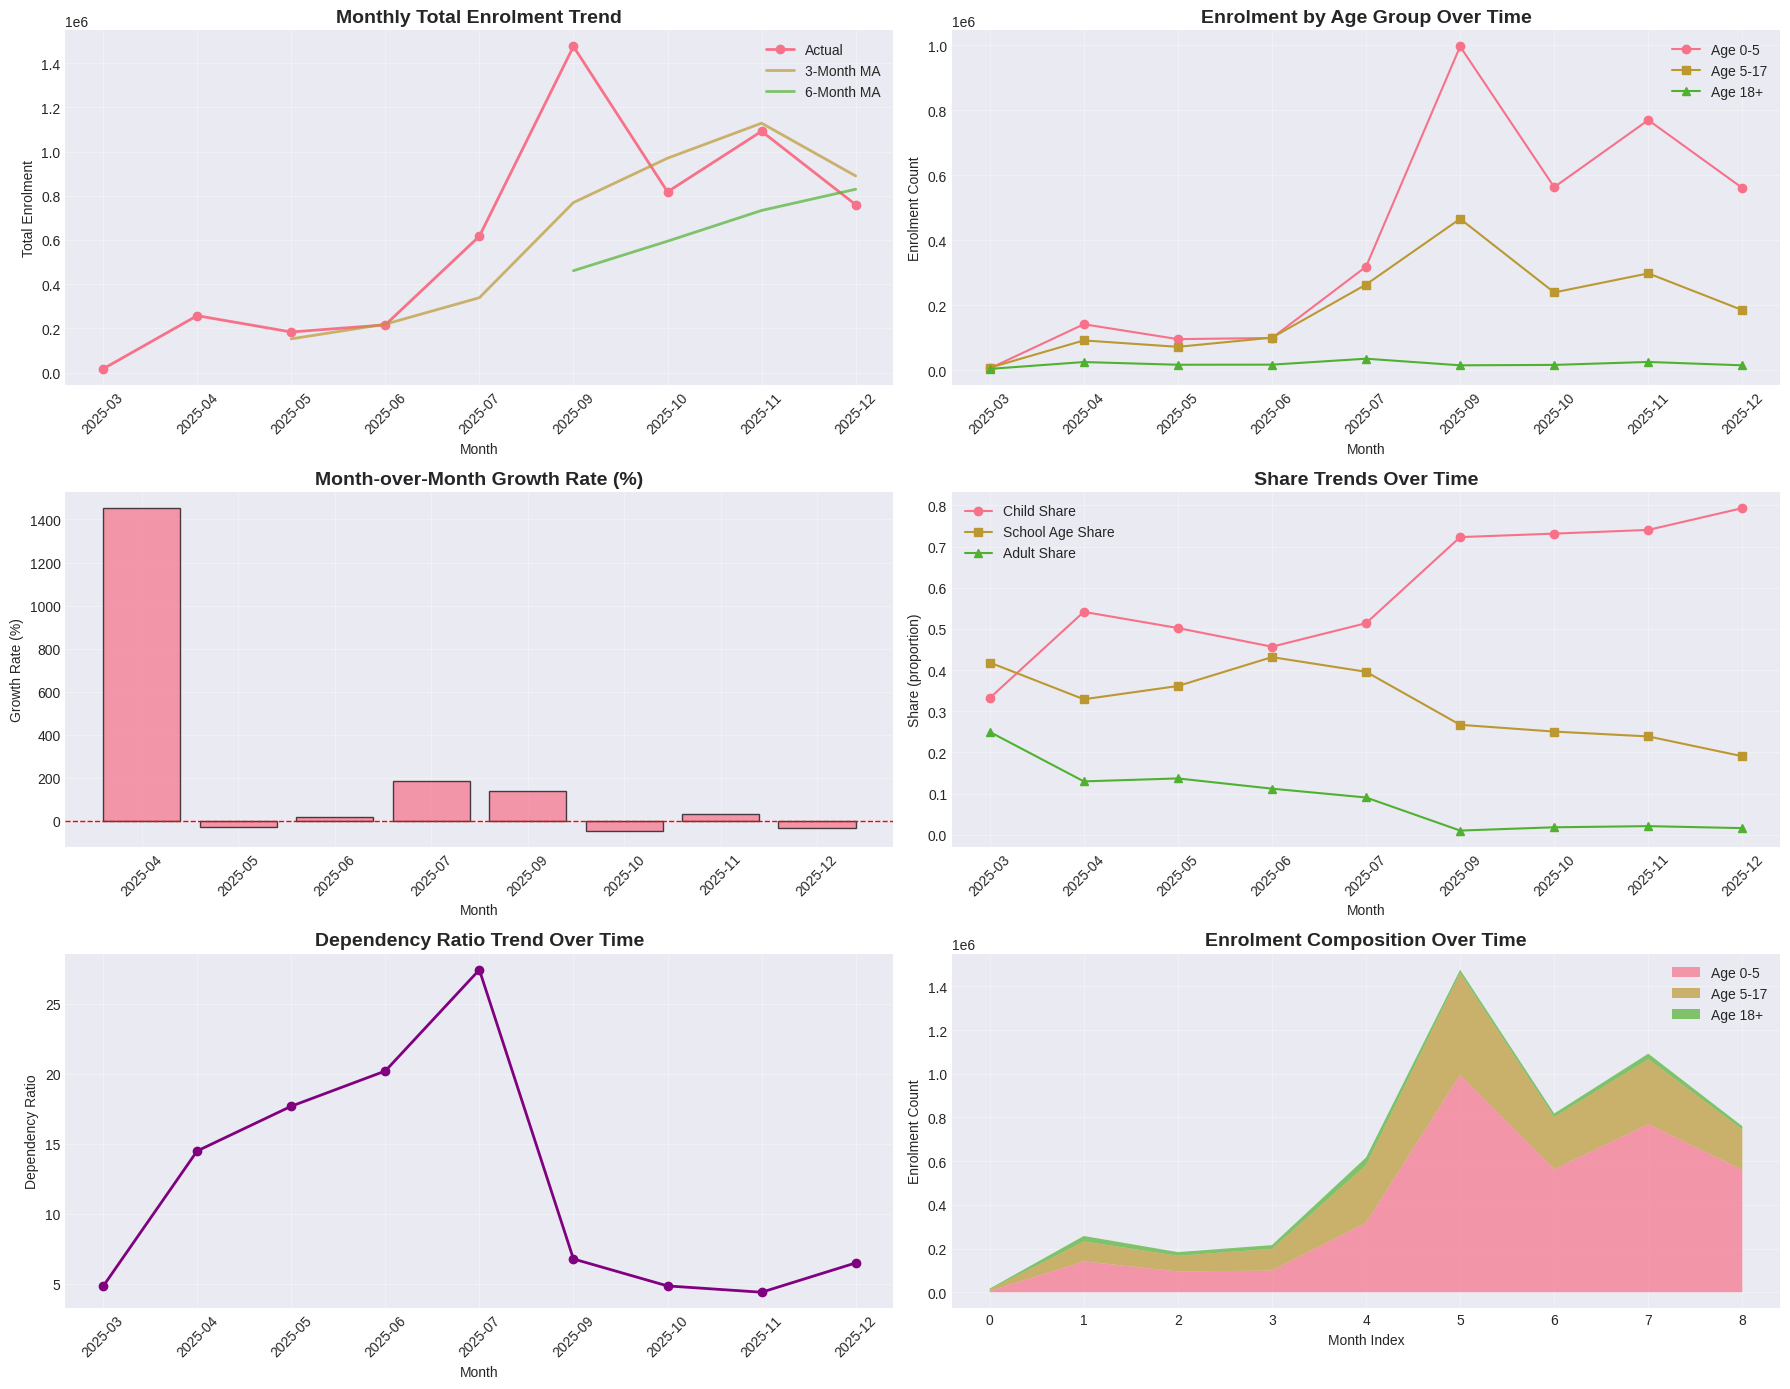

In [27]:
monthly = df.groupby('year_month').agg({
    'total_enrolment': 'sum',
    'age_0_5': 'sum',
    'age_5_17': 'sum',
    'age_18_greater': 'sum',
    'child_share': 'mean',
    'school_age_share': 'mean',
    'adult_share': 'mean',
    'dependency_ratio': 'mean'
}).reset_index()

monthly['year_month'] = monthly['year_month'].astype(str)
monthly['enrolment_growth'] = monthly['total_enrolment'].pct_change() * 100
monthly['rolling_3m'] = monthly['total_enrolment'].rolling(3).mean()
monthly['rolling_6m'] = monthly['total_enrolment'].rolling(6).mean()

fig, axes = plt.subplots(3, 2, figsize=(18, 14))

# Total enrolment trend
axes[0, 0].plot(monthly['year_month'], monthly['total_enrolment'],
                marker='o', linewidth=2, label='Actual')
axes[0, 0].plot(monthly['year_month'], monthly['rolling_3m'],
                linewidth=2, label='3-Month MA', alpha=0.7)
axes[0, 0].plot(monthly['year_month'], monthly['rolling_6m'],
                linewidth=2, label='6-Month MA', alpha=0.7)
axes[0, 0].set_title('Monthly Total Enrolment Trend', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Month')
axes[0, 0].set_ylabel('Total Enrolment')
axes[0, 0].legend()
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# Age groups over time
axes[0, 1].plot(monthly['year_month'], monthly['age_0_5'], marker='o', label='Age 0-5')
axes[0, 1].plot(monthly['year_month'], monthly['age_5_17'], marker='s', label='Age 5-17')
axes[0, 1].plot(monthly['year_month'], monthly['age_18_greater'], marker='^', label='Age 18+')
axes[0, 1].set_title('Enrolment by Age Group Over Time', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Month')
axes[0, 1].set_ylabel('Enrolment Count')
axes[0, 1].legend()
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# Growth rate
axes[1, 0].bar(monthly['year_month'], monthly['enrolment_growth'],
               edgecolor='black', alpha=0.7)
axes[1, 0].axhline(y=0, color='red', linestyle='--', linewidth=1)
axes[1, 0].set_title('Month-over-Month Growth Rate (%)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Growth Rate (%)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# Share trends
axes[1, 1].plot(monthly['year_month'], monthly['child_share'], marker='o', label='Child Share')
axes[1, 1].plot(monthly['year_month'], monthly['school_age_share'], marker='s', label='School Age Share')
axes[1, 1].plot(monthly['year_month'], monthly['adult_share'], marker='^', label='Adult Share')
axes[1, 1].set_title('Share Trends Over Time', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Share (proportion)')
axes[1, 1].legend()
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

# Dependency ratio trend
axes[2, 0].plot(monthly['year_month'], monthly['dependency_ratio'],
                marker='o', color='purple', linewidth=2)
axes[2, 0].set_title('Dependency Ratio Trend Over Time', fontsize=14, fontweight='bold')
axes[2, 0].set_xlabel('Month')
axes[2, 0].set_ylabel('Dependency Ratio')
axes[2, 0].tick_params(axis='x', rotation=45)
axes[2, 0].grid(True, alpha=0.3)

# Stacked area chart
axes[2, 1].fill_between(range(len(monthly)), 0, monthly['age_0_5'],
                         label='Age 0-5', alpha=0.7)
axes[2, 1].fill_between(range(len(monthly)), monthly['age_0_5'],
                         monthly['age_0_5'] + monthly['age_5_17'],
                         label='Age 5-17', alpha=0.7)
axes[2, 1].fill_between(range(len(monthly)),
                         monthly['age_0_5'] + monthly['age_5_17'],
                         monthly['total_enrolment'],
                         label='Age 18+', alpha=0.7)
axes[2, 1].set_title('Enrolment Composition Over Time', fontsize=14, fontweight='bold')
axes[2, 1].set_xlabel('Month Index')
axes[2, 1].set_ylabel('Enrolment Count')
axes[2, 1].legend()
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.5 State-wise Analysis

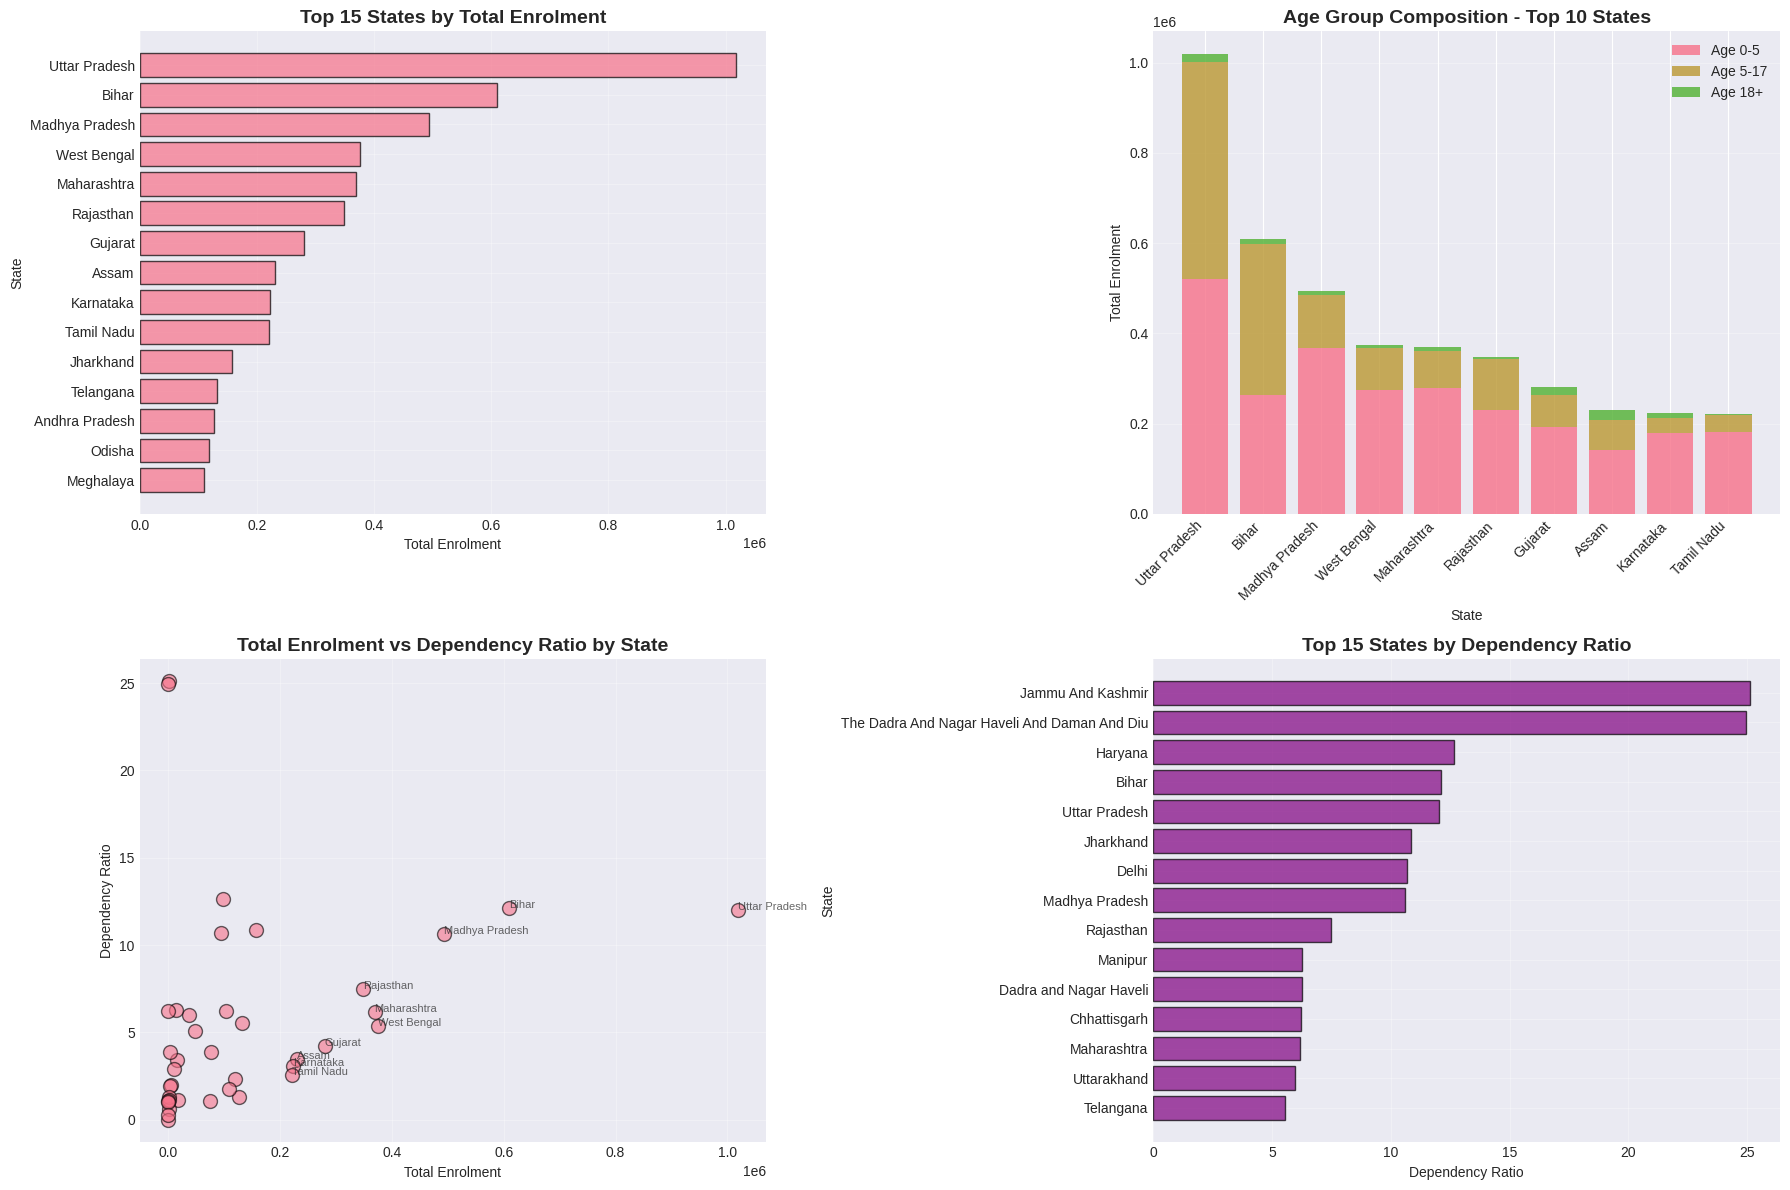

In [28]:
state_summary = df.groupby('state').agg({
    'total_enrolment': 'sum',
    'age_0_5': 'sum',
    'age_5_17': 'sum',
    'age_18_greater': 'sum',
    'child_share': 'mean',
    'school_age_share': 'mean',
    'adult_share': 'mean',
    'dependency_ratio': 'mean'
}).reset_index()

state_summary = state_summary.sort_values('total_enrolment', ascending=False)

fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Top 15 states by total enrolment
top15_states = state_summary.head(15)
axes[0, 0].barh(top15_states['state'], top15_states['total_enrolment'],
                edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Top 15 States by Total Enrolment', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Total Enrolment')
axes[0, 0].set_ylabel('State')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(True, alpha=0.3)

# Stacked bar chart for top 10 states
top10_for_stack = state_summary.head(10)
x_pos = np.arange(len(top10_for_stack))
axes[0, 1].bar(x_pos, top10_for_stack['age_0_5'], label='Age 0-5', alpha=0.8)
axes[0, 1].bar(x_pos, top10_for_stack['age_5_17'],
               bottom=top10_for_stack['age_0_5'], label='Age 5-17', alpha=0.8)
axes[0, 1].bar(x_pos, top10_for_stack['age_18_greater'],
               bottom=top10_for_stack['age_0_5'] + top10_for_stack['age_5_17'],
               label='Age 18+', alpha=0.8)
axes[0, 1].set_title('Age Group Composition - Top 10 States', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('State')
axes[0, 1].set_ylabel('Total Enrolment')
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(top10_for_stack['state'], rotation=45, ha='right')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# State scatter: Total enrolment vs Dependency ratio
axes[1, 0].scatter(state_summary['total_enrolment'], state_summary['dependency_ratio'],
                   s=100, alpha=0.6, edgecolors='black')
for idx, row in state_summary.head(10).iterrows():
    axes[1, 0].annotate(row['state'], (row['total_enrolment'], row['dependency_ratio']),
                        fontsize=8, alpha=0.7)
axes[1, 0].set_title('Total Enrolment vs Dependency Ratio by State', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Total Enrolment')
axes[1, 0].set_ylabel('Dependency Ratio')
axes[1, 0].grid(True, alpha=0.3)

# Top 15 states by dependency ratio
top15_dep = state_summary.sort_values('dependency_ratio', ascending=False).head(15)
axes[1, 1].barh(top15_dep['state'], top15_dep['dependency_ratio'],
                edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].set_title('Top 15 States by Dependency Ratio', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Dependency Ratio')
axes[1, 1].set_ylabel('State')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 4.6 Share Composition Analysis

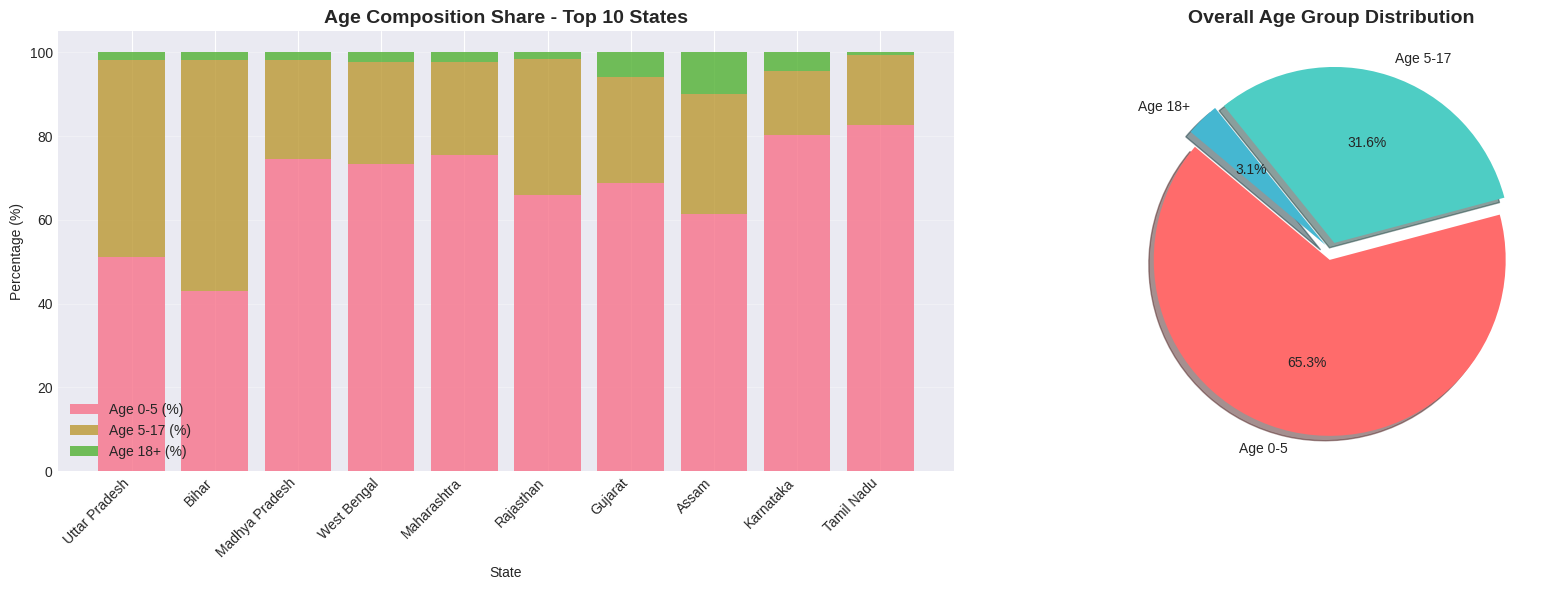

In [29]:
# Stacked percentage composition for top 10 states
top10_states_comp = state_summary.head(10).copy()
top10_states_comp['total'] = (top10_states_comp['age_0_5'] +
                               top10_states_comp['age_5_17'] +
                               top10_states_comp['age_18_greater'])
top10_states_comp['age_0_5_pct'] = (top10_states_comp['age_0_5'] /
                                     top10_states_comp['total']) * 100
top10_states_comp['age_5_17_pct'] = (top10_states_comp['age_5_17'] /
                                      top10_states_comp['total']) * 100
top10_states_comp['age_18_greater_pct'] = (top10_states_comp['age_18_greater'] /
                                            top10_states_comp['total']) * 100

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

x_pos = np.arange(len(top10_states_comp))
axes[0].bar(x_pos, top10_states_comp['age_0_5_pct'], label='Age 0-5 (%)', alpha=0.8)
axes[0].bar(x_pos, top10_states_comp['age_5_17_pct'],
            bottom=top10_states_comp['age_0_5_pct'], label='Age 5-17 (%)', alpha=0.8)
axes[0].bar(x_pos, top10_states_comp['age_18_greater_pct'],
            bottom=top10_states_comp['age_0_5_pct'] + top10_states_comp['age_5_17_pct'],
            label='Age 18+ (%)', alpha=0.8)
axes[0].set_title('Age Composition Share - Top 10 States', fontsize=14, fontweight='bold')
axes[0].set_xlabel('State')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(top10_states_comp['state'], rotation=45, ha='right')
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Pie chart for overall composition
total_age_0_5 = df['age_0_5'].sum()
total_age_5_17 = df['age_5_17'].sum()
total_age_18_plus = df['age_18_greater'].sum()

sizes = [total_age_0_5, total_age_5_17, total_age_18_plus]
labels = ['Age 0-5', 'Age 5-17', 'Age 18+']
colors = ['#FF6B6B', '#4ECDC4', '#45B7D1']
explode = (0.05, 0.05, 0.05)

axes[1].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%',
            shadow=True, startangle=140)
axes[1].set_title('Overall Age Group Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

### 4.7 Heatmap - Top States Monthly Activity

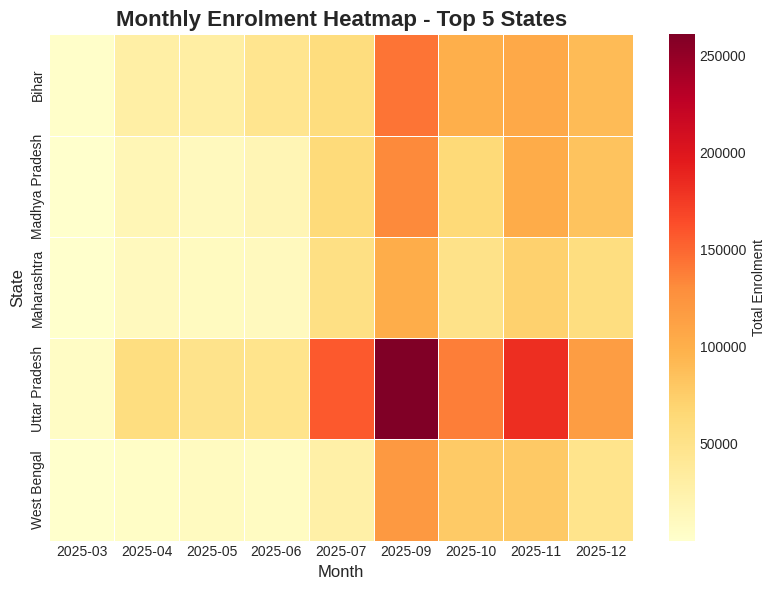

In [60]:
top5_states_list = state_summary.head(5)['state'].tolist()
state_monthly_pivot = df[df['state'].isin(top5_states_list)].groupby(
    ['state', 'year_month']
)['total_enrolment'].sum().unstack(fill_value=0)

state_monthly_pivot.columns = state_monthly_pivot.columns.astype(str)

plt.figure(figsize=(8, 6))
sns.heatmap(state_monthly_pivot, cmap='YlOrRd', annot=False, fmt='.0f',
            linewidths=0.5, cbar_kws={'label': 'Total Enrolment'})
plt.title('Monthly Enrolment Heatmap - Top 5 States', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('State', fontsize=12)
plt.tight_layout()
plt.show()

### 4.8 Correlation Analysis

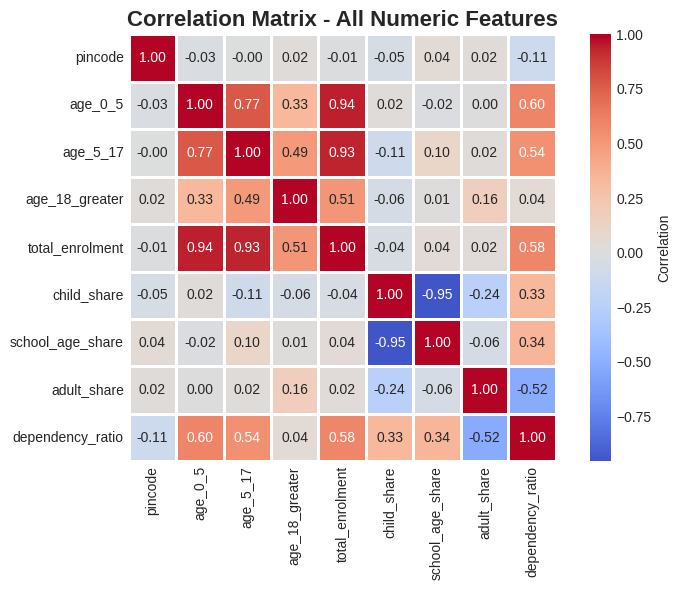

In [61]:
# Select numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['year', 'month', 'quarter',
                                                             'day_of_week', 'week_of_year']]

corr_matrix = df[numeric_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={'label': 'Correlation'})
plt.title('Correlation Matrix - All Numeric Features', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


CORRELATIONS WITH TOTAL ENROLMENT
total_enrolment     1.000000
age_0_5             0.941164
age_5_17            0.934479
dependency_ratio    0.582429
age_18_greater      0.511727
school_age_share    0.036723
adult_share         0.024795
pincode            -0.013841
child_share        -0.043113
Name: total_enrolment, dtype: float64


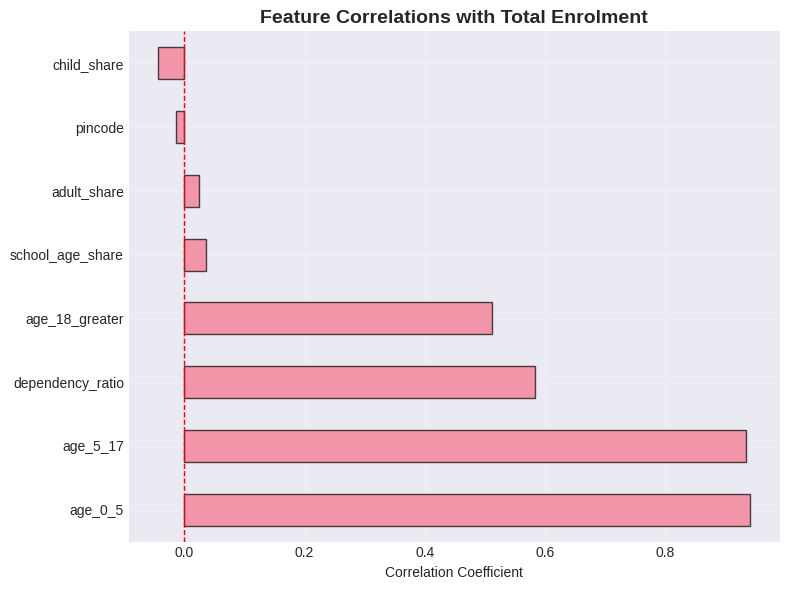

In [62]:
# Focus on total enrolment correlations
enrol_corr = corr_matrix['total_enrolment'].sort_values(ascending=False)
print("\n" + "="*80)
print("CORRELATIONS WITH TOTAL ENROLMENT")
print("="*80)
print(enrol_corr)

plt.figure(figsize=(8, 6))
enrol_corr[1:].plot(kind='barh', edgecolor='black', alpha=0.7)
plt.title('Feature Correlations with Total Enrolment', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient')
plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. ADVANCED FEATURE ENGINEERING

In [33]:
print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)


FEATURE ENGINEERING


In [34]:
# Sort data
df = df.sort_values(['state', 'date'])

In [35]:
# State-level monthly aggregation for feature engineering
state_monthly = df.groupby(['state', 'year_month']).agg({
    'total_enrolment': 'sum',
    'age_0_5': 'sum',
    'age_5_17': 'sum',
    'age_18_greater': 'sum',
    'child_share': 'mean',
    'school_age_share': 'mean',
    'adult_share': 'mean',
    'dependency_ratio': 'mean'
}).reset_index()

state_monthly = state_monthly.sort_values(['state', 'year_month'])

In [36]:
# Growth rates
state_monthly['enrolment_growth'] = state_monthly.groupby('state')['total_enrolment'].pct_change() * 100
state_monthly['child_growth'] = state_monthly.groupby('state')['age_0_5'].pct_change() * 100
state_monthly['school_growth'] = state_monthly.groupby('state')['age_5_17'].pct_change() * 100
state_monthly['adult_growth'] = state_monthly.groupby('state')['age_18_greater'].pct_change() * 100

In [37]:
# Share shifts
state_monthly['child_share_shift'] = state_monthly.groupby('state')['child_share'].diff().abs()
state_monthly['school_share_shift'] = state_monthly.groupby('state')['school_age_share'].diff().abs()
state_monthly['adult_share_shift'] = state_monthly.groupby('state')['adult_share'].diff().abs()

In [38]:
# Volatility metrics (3-month rolling std)
state_monthly['enrolment_volatility'] = state_monthly.groupby('state')['total_enrolment'].transform(
    lambda x: x.rolling(3).std()
)
state_monthly['dependency_volatility'] = state_monthly.groupby('state')['dependency_ratio'].transform(
    lambda x: x.rolling(3).std()
)

In [39]:
# Rolling averages
state_monthly['enrolment_ma3'] = state_monthly.groupby('state')['total_enrolment'].transform(
    lambda x: x.rolling(3).mean()
)
state_monthly['enrolment_ma6'] = state_monthly.groupby('state')['total_enrolment'].transform(
    lambda x: x.rolling(6).mean()
)

In [40]:
# Replace infinities
state_monthly.replace([np.inf, -np.inf], np.nan, inplace=True)

print("New features created:")
print(['enrolment_growth', 'child_growth', 'school_growth', 'adult_growth',
       'child_share_shift', 'school_share_shift', 'adult_share_shift',
       'enrolment_volatility', 'dependency_volatility', 'enrolment_ma3', 'enrolment_ma6'])

New features created:
['enrolment_growth', 'child_growth', 'school_growth', 'adult_growth', 'child_share_shift', 'school_share_shift', 'adult_share_shift', 'enrolment_volatility', 'dependency_volatility', 'enrolment_ma3', 'enrolment_ma6']


## 6. CLUSTERING ANALYSIS

In [41]:
print("\n" + "="*80)
print("CLUSTERING ANALYSIS")
print("="*80)


CLUSTERING ANALYSIS


In [42]:
# Prepare ML dataset - aggregate by state
ml_df = state_monthly.groupby('state').agg({
    'total_enrolment': 'mean',
    'enrolment_growth': 'mean',
    'child_share': 'mean',
    'school_age_share': 'mean',
    'adult_share': 'mean',
    'dependency_ratio': 'mean',
    'child_share_shift': 'mean',
    'enrolment_volatility': 'mean'
}).dropna().reset_index()

print(f"States for clustering: {len(ml_df)}")
print(f"Features: {ml_df.columns.tolist()}")

States for clustering: 37
Features: ['state', 'total_enrolment', 'enrolment_growth', 'child_share', 'school_age_share', 'adult_share', 'dependency_ratio', 'child_share_shift', 'enrolment_volatility']


In [43]:
# Standardize features
X = ml_df.drop('state', axis=1)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

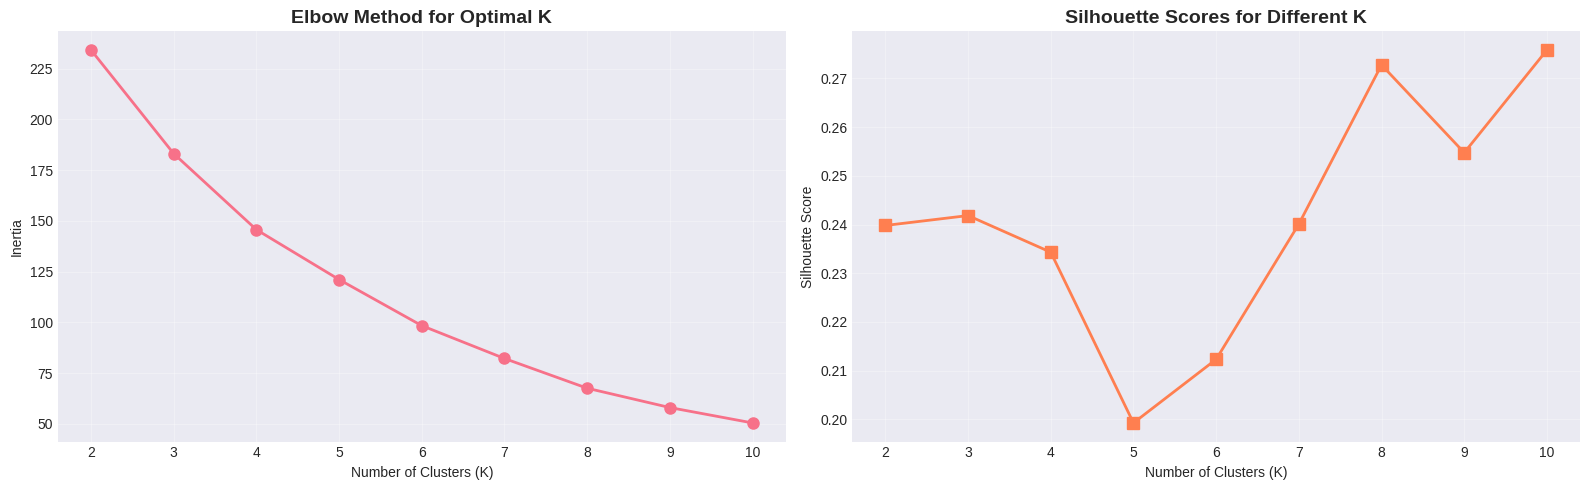

In [45]:
# Elbow method
inertias = []
silhouette_scores = []
K_range = range(2, 11)

from sklearn.metrics import silhouette_score

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Elbow curve
axes[0].plot(K_range, inertias, marker='o', linewidth=2, markersize=8)
axes[0].set_title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia')
axes[0].grid(True, alpha=0.3)

# Silhouette scores
axes[1].plot(K_range, silhouette_scores, marker='s', linewidth=2, markersize=8, color='coral')
axes[1].set_title('Silhouette Scores for Different K', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [46]:
# Apply K-Means with optimal clusters
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
ml_df['cluster'] = kmeans.fit_predict(X_scaled)

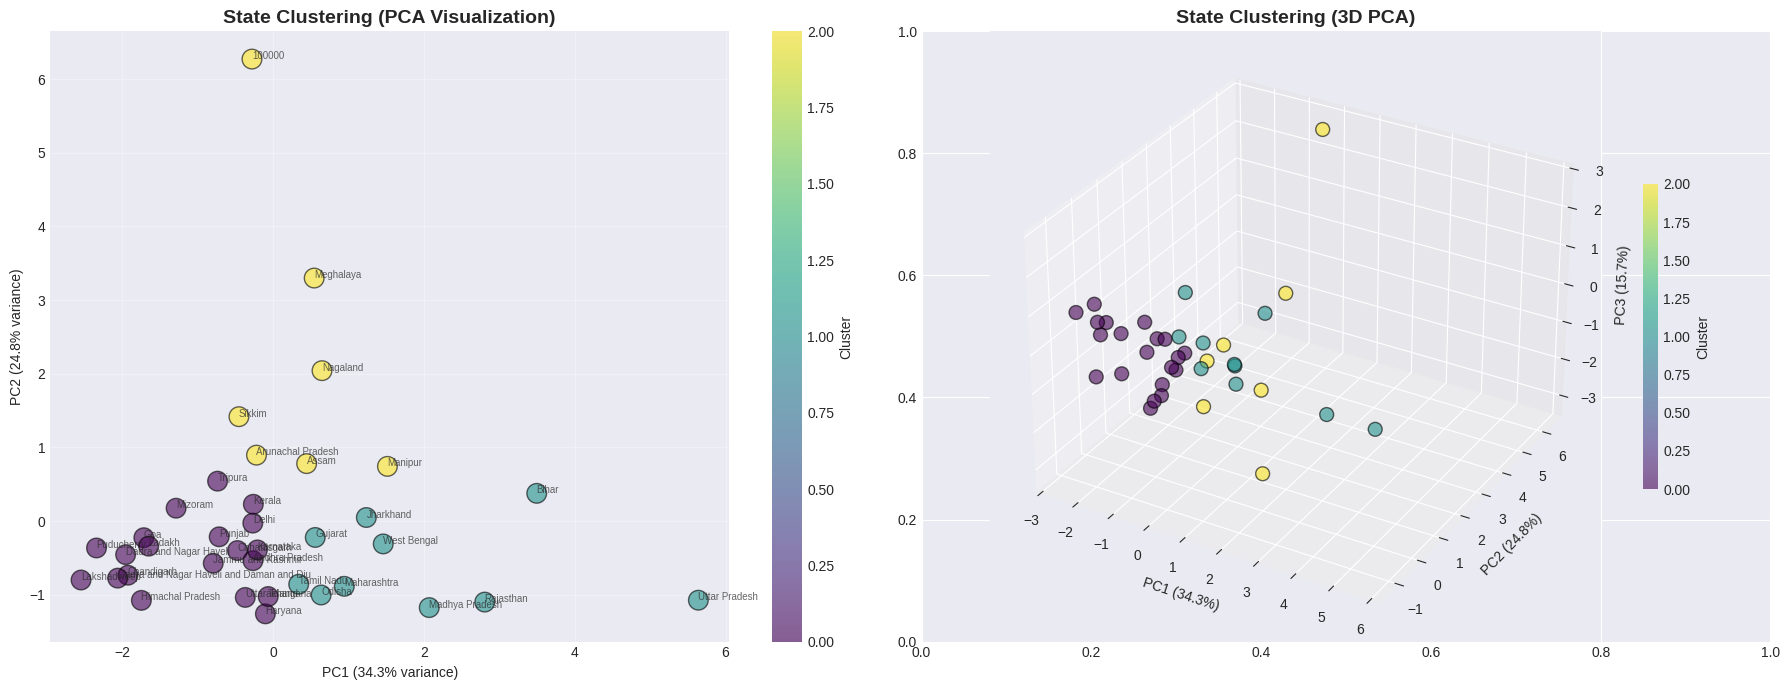

In [64]:
# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# PCA scatter plot
scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], c=ml_df['cluster'],
                          s=200, alpha=0.6, edgecolors='black', cmap='viridis')
axes[0].set_title('State Clustering (PCA Visualization)', fontsize=14, fontweight='bold')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0], label='Cluster')

# Annotate states
for idx, row in ml_df.iterrows():
    axes[0].annotate(row['state'], (X_pca[idx, 0], X_pca[idx, 1]),
                     fontsize=7, alpha=0.7)

# 3D PCA (first 3 components)
from mpl_toolkits.mplot3d import Axes3D
pca_3d = PCA(n_components=3)
X_pca_3d = pca_3d.fit_transform(X_scaled)

ax_3d = fig.add_subplot(122, projection='3d')
scatter_3d = ax_3d.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2],
                           c=ml_df['cluster'], s=100, alpha=0.6,
                           edgecolors='black', cmap='viridis')
ax_3d.set_title('State Clustering (3D PCA)', fontsize=14, fontweight='bold')
ax_3d.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]*100:.1f}%)')
ax_3d.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]*100:.1f}%)')
ax_3d.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]*100:.1f}%)')
plt.colorbar(scatter_3d, ax=ax_3d, label='Cluster', shrink=0.5)

plt.tight_layout()
plt.show()

In [50]:
# Cluster summary
cluster_summary = ml_df.groupby('cluster').agg({
    'total_enrolment': ['mean', 'std', 'count'],
    'enrolment_growth': ['mean', 'std'],
    'child_share': ['mean', 'std'],
    'school_age_share': ['mean', 'std'],
    'adult_share': ['mean', 'std'],
    'dependency_ratio': ['mean', 'std'],
    'enrolment_volatility': ['mean', 'std']
})

print("\n" + "="*80)
print("CLUSTER SUMMARY STATISTICS")
print("="*80)
print(cluster_summary)


CLUSTER SUMMARY STATISTICS
        total_enrolment                     enrolment_growth              \
                   mean           std count             mean         std   
cluster                                                                    
0           6577.026746   7252.943688    20       283.130541  328.376210   
1          45243.365278  28311.947756    10       833.206867  764.836790   
2           6099.390079   9574.858670     7       193.870664  301.520898   

        child_share           school_age_share           adult_share  \
               mean       std             mean       std        mean   
cluster                                                                
0          0.765867  0.096723         0.172318  0.078588    0.061815   
1          0.615024  0.115565         0.321247  0.121169    0.063729   
2          0.340750  0.184365         0.456373  0.134787    0.202877   

                  dependency_ratio           enrolment_volatility  \
             

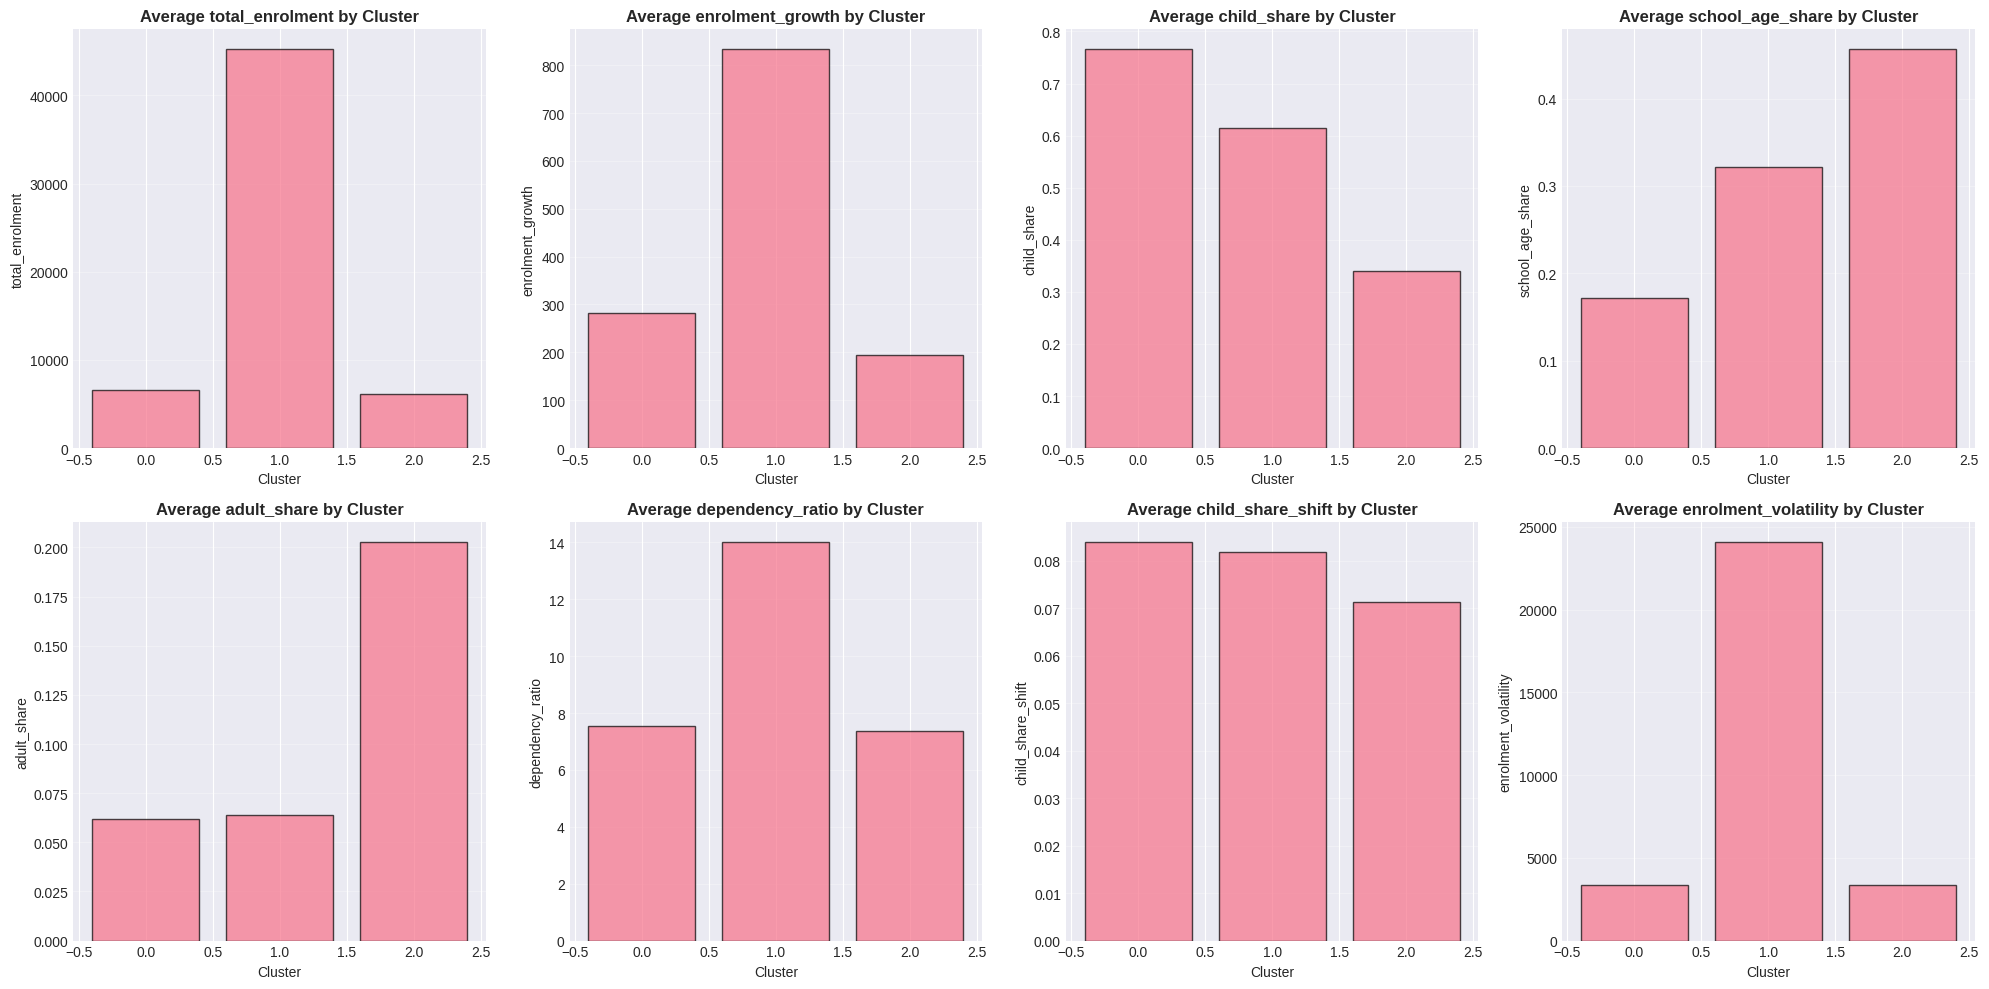

In [51]:
# Cluster characteristics comparison
features_to_plot = ['total_enrolment', 'enrolment_growth', 'child_share',
                    'school_age_share', 'adult_share', 'dependency_ratio',
                    'child_share_shift', 'enrolment_volatility']

n_features = len(features_to_plot)
n_rows = (n_features + 3) // 4
n_cols = min(4, n_features)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten() if n_features > 1 else [axes]

for idx, feature in enumerate(features_to_plot):
    cluster_means = ml_df.groupby('cluster')[feature].mean()
    axes[idx].bar(cluster_means.index, cluster_means.values,
                  edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Average {feature} by Cluster', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Cluster')
    axes[idx].set_ylabel(feature)
    axes[idx].grid(True, alpha=0.3, axis='y')

# Hide extra subplots
for idx in range(n_features, len(axes)):
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

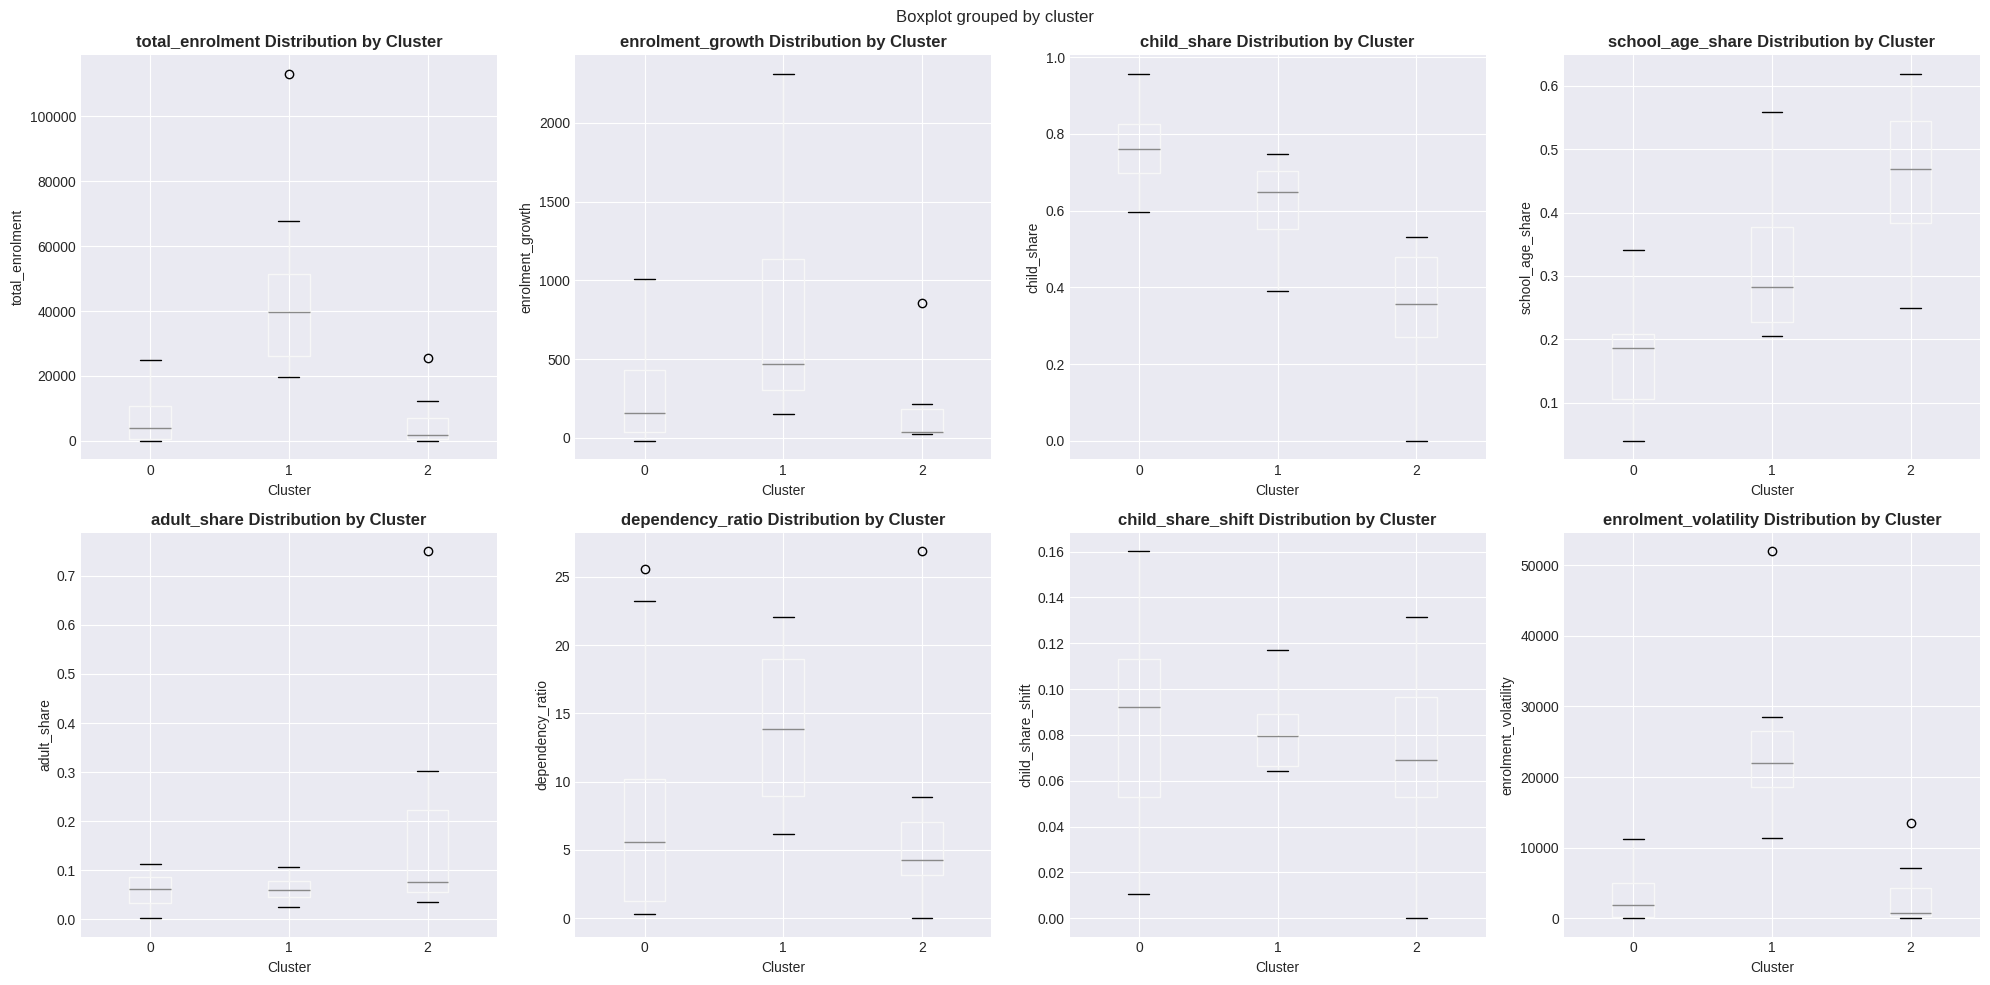

In [52]:
# Box plots for each feature by cluster
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.flatten()

for idx, feature in enumerate(features_to_plot):
    ml_df.boxplot(column=feature, by='cluster', ax=axes[idx])
    axes[idx].set_title(f'{feature} Distribution by Cluster', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Cluster')
    axes[idx].set_ylabel(feature)
    plt.sca(axes[idx])
    plt.xticks([1, 2, 3])

plt.tight_layout()
plt.show()

In [53]:
# States in each cluster
print("\n" + "="*80)
print("STATES BY CLUSTER")
print("="*80)
for cluster_id in sorted(ml_df['cluster'].unique()):
    states_in_cluster = ml_df[ml_df['cluster'] == cluster_id]['state'].tolist()
    print(f"\nCluster {cluster_id} ({len(states_in_cluster)} states):")
    print(", ".join(states_in_cluster))


STATES BY CLUSTER

Cluster 0 (20 states):
Andhra Pradesh, Chandigarh, Chhattisgarh, Dadra and Nagar Haveli, Dadra and Nagar Haveli and Daman and Diu, Delhi, Goa, Haryana, Himachal Pradesh, Jammu and Kashmir, Karnataka, Kerala, Ladakh, Lakshadweep, Mizoram, Puducherry, Punjab, Telangana, Tripura, Uttarakhand

Cluster 1 (10 states):
Bihar, Gujarat, Jharkhand, Madhya Pradesh, Maharashtra, Odisha, Rajasthan, Tamil Nadu, Uttar Pradesh, West Bengal

Cluster 2 (7 states):
100000, Arunachal Pradesh, Assam, Manipur, Meghalaya, Nagaland, Sikkim


In [54]:
# Cluster profiles
print("\n" + "="*80)
print("CLUSTER PROFILES")
print("="*80)

for cluster_id in sorted(ml_df['cluster'].unique()):
    cluster_data = ml_df[ml_df['cluster'] == cluster_id]
    print(f"\n{'='*60}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*60}")
    print(f"Number of states: {len(cluster_data)}")
    print(f"Average total enrolment: {cluster_data['total_enrolment'].mean():.2f}")
    print(f"Average enrolment growth: {cluster_data['enrolment_growth'].mean():.2f}%")
    print(f"Average child share: {cluster_data['child_share'].mean():.3f}")
    print(f"Average school age share: {cluster_data['school_age_share'].mean():.3f}")
    print(f"Average adult share: {cluster_data['adult_share'].mean():.3f}")
    print(f"Average dependency ratio: {cluster_data['dependency_ratio'].mean():.3f}")
    print(f"Average volatility: {cluster_data['enrolment_volatility'].mean():.2f}")


CLUSTER PROFILES

CLUSTER 0
Number of states: 20
Average total enrolment: 6577.03
Average enrolment growth: 283.13%
Average child share: 0.766
Average school age share: 0.172
Average adult share: 0.062
Average dependency ratio: 7.550
Average volatility: 3353.21

CLUSTER 1
Number of states: 10
Average total enrolment: 45243.37
Average enrolment growth: 833.21%
Average child share: 0.615
Average school age share: 0.321
Average adult share: 0.064
Average dependency ratio: 14.020
Average volatility: 24101.61

CLUSTER 2
Number of states: 7
Average total enrolment: 6099.39
Average enrolment growth: 193.87%
Average child share: 0.341
Average school age share: 0.456
Average adult share: 0.203
Average dependency ratio: 7.357
Average volatility: 3346.35


## 7. COMPARATIVE ANALYSIS

In [55]:
print("\n" + "="*80)
print("COMPARATIVE ANALYSIS")
print("="*80)


COMPARATIVE ANALYSIS


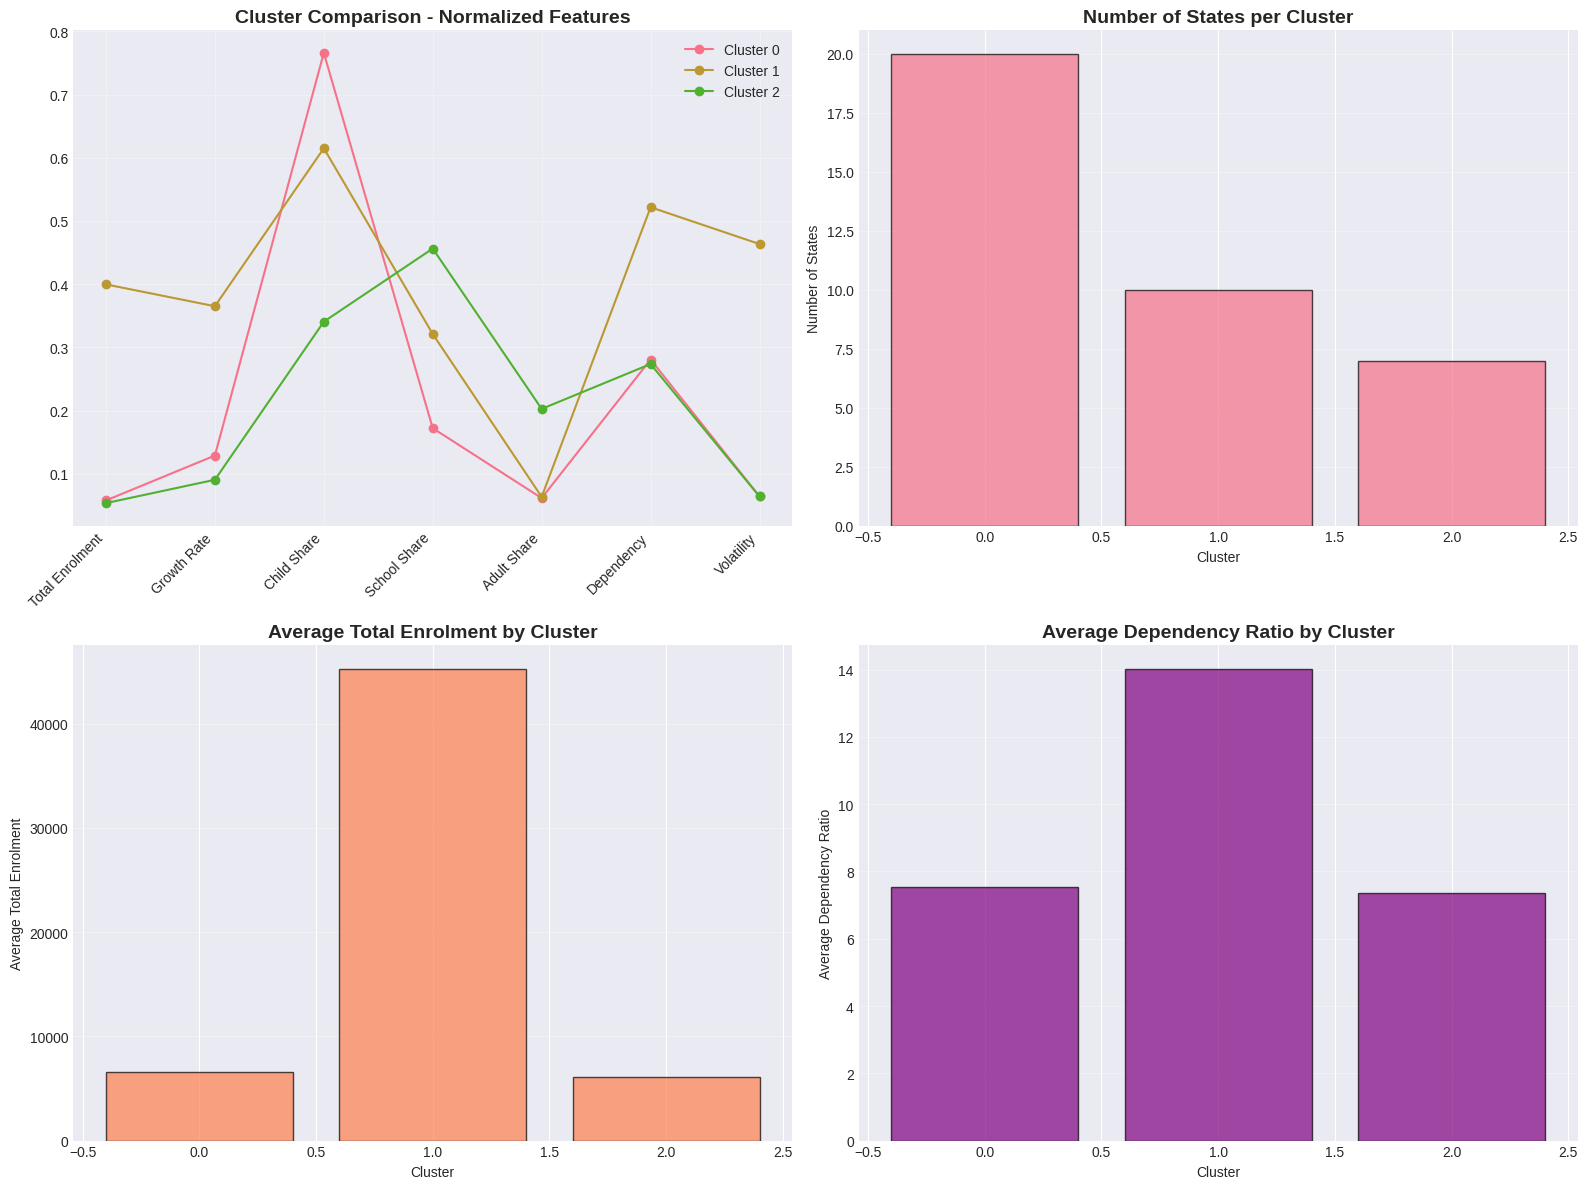

In [57]:
# Compare clusters side by side
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Radar chart data preparation
categories = ['Total Enrolment', 'Growth Rate', 'Child Share',
              'School Share', 'Adult Share', 'Dependency', 'Volatility']

for cluster_id in sorted(ml_df['cluster'].unique()):
    cluster_data = ml_df[ml_df['cluster'] == cluster_id]

    values = [
        cluster_data['total_enrolment'].mean() / ml_df['total_enrolment'].max(),
        (cluster_data['enrolment_growth'].mean() - ml_df['enrolment_growth'].min()) /
        (ml_df['enrolment_growth'].max() - ml_df['enrolment_growth'].min() + 0.001),
        cluster_data['child_share'].mean(),
        cluster_data['school_age_share'].mean(),
        cluster_data['adult_share'].mean(),
        cluster_data['dependency_ratio'].mean() / ml_df['dependency_ratio'].max(),
        cluster_data['enrolment_volatility'].mean() / ml_df['enrolment_volatility'].max()
    ]

    axes[0, 0].plot(categories, values, marker='o', label=f'Cluster {cluster_id}')

axes[0, 0].set_title('Cluster Comparison - Normalized Features', fontsize=14, fontweight='bold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)
plt.setp(axes[0, 0].xaxis.get_majorticklabels(), rotation=45, ha='right')

# Cluster sizes
cluster_sizes = ml_df['cluster'].value_counts().sort_index()
axes[0, 1].bar(cluster_sizes.index, cluster_sizes.values, edgecolor='black', alpha=0.7)
axes[0, 1].set_title('Number of States per Cluster', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Cluster')
axes[0, 1].set_ylabel('Number of States')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Average enrolment by cluster
avg_enrolment = ml_df.groupby('cluster')['total_enrolment'].mean()
axes[1, 0].bar(avg_enrolment.index, avg_enrolment.values,
               edgecolor='black', alpha=0.7, color='coral')
axes[1, 0].set_title('Average Total Enrolment by Cluster', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Cluster')
axes[1, 0].set_ylabel('Average Total Enrolment')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Dependency ratio comparison
avg_dep_ratio = ml_df.groupby('cluster')['dependency_ratio'].mean()
axes[1, 1].bar(avg_dep_ratio.index, avg_dep_ratio.values,
               edgecolor='black', alpha=0.7, color='purple')
axes[1, 1].set_title('Average Dependency Ratio by Cluster', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Cluster')
axes[1, 1].set_ylabel('Average Dependency Ratio')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 8. FINAL SUMMARY

In [58]:
print("\n" + "="*80)
print("ANALYSIS SUMMARY")
print("="*80)


ANALYSIS SUMMARY


In [59]:
summary_stats = {
    'Total Records': df.shape[0],
    'Total States': df['state'].nunique(),
    'Date Range': f"{df['date'].min()} to {df['date'].max()}",
    'Total Enrolment (Sum)': df['total_enrolment'].sum(),
    'Average Enrolment per Record': df['total_enrolment'].mean(),
    'Total Age 0-5': df['age_0_5'].sum(),
    'Total Age 5-17': df['age_5_17'].sum(),
    'Total Age 18+': df['age_18_greater'].sum(),
    'Average Child Share': df['child_share'].mean(),
    'Average School Age Share': df['school_age_share'].mean(),
    'Average Adult Share': df['adult_share'].mean(),
    'Average Dependency Ratio': df['dependency_ratio'].mean(),
    'Number of Clusters': n_clusters
}

for key, value in summary_stats.items():
    if isinstance(value, float):
        print(f"{key}: {value:.3f}")
    else:
        print(f"{key}: {value}")

print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

print(f"\n1. Age Distribution:")
print(f"   - Children (0-5): {(df['age_0_5'].sum() / df['total_enrolment'].sum() * 100):.1f}%")
print(f"   - School Age (5-17): {(df['age_5_17'].sum() / df['total_enrolment'].sum() * 100):.1f}%")
print(f"   - Adults (18+): {(df['age_18_greater'].sum() / df['total_enrolment'].sum() * 100):.1f}%")

print(f"\n2. Top 5 States by Enrolment:")
for idx, (state, enrolment) in enumerate(state_summary.head(5)[['state', 'total_enrolment']].values, 1):
    print(f"   {idx}. {state}: {enrolment:,.0f}")

print(f"\n3. Dependency Metrics:")
print(f"   - Average Dependency Ratio: {df['dependency_ratio'].mean():.3f}")
print(f"   - Highest Dependency Ratio State: {state_summary.sort_values('dependency_ratio', ascending=False).iloc[0]['state']}")
print(f"   - Lowest Dependency Ratio State: {state_summary.sort_values('dependency_ratio').iloc[0]['state']}")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)

Total Records: 1006029
Total States: 55
Date Range: 2025-03-02 00:00:00 to 2025-12-31 00:00:00
Total Enrolment (Sum): 5435702
Average Enrolment per Record: 5.403
Total Age 0-5: 3546965
Total Age 5-17: 1720384
Total Age 18+: 168353
Average Child Share: 0.740
Average School Age Share: 0.244
Average Adult Share: 0.016
Average Dependency Ratio: 6.716
Number of Clusters: 3

KEY INSIGHTS

1. Age Distribution:
   - Children (0-5): 65.3%
   - School Age (5-17): 31.6%
   - Adults (18+): 3.1%

2. Top 5 States by Enrolment:
   1. Uttar Pradesh: 1,018,629
   2. Bihar: 609,585
   3. Madhya Pradesh: 493,970
   4. West Bengal: 375,297
   5. Maharashtra: 369,139

3. Dependency Metrics:
   - Average Dependency Ratio: 6.716
   - Highest Dependency Ratio State: Jammu And Kashmir
   - Lowest Dependency Ratio State: 100000

ANALYSIS COMPLETE
